# Numerical Feature Analysis

**!!! ÖNEMLİ !!!**
<br>
**Bu notebooku Google Colab'den hazırladım. Bu sebeple dosya yolu 'content' pathini içeriyor. Ayrıca Abdulkadirin yaptığı notebooku da pkl olarak kaydedip buradan açtım. Bu sebeple modelleme aşamasında (veya notebook genel olarak incelenirken) tercihe göre kodlar değişebilir** 

In [5]:
import pickle
with open("/content/train_processed.pkl", "rb") as f:
    df = pickle.load(f)

In [6]:
# 1) Numerik kolonların belirlenmesi
numeric_cols = df.select_dtypes(include=['int16','int32','int64','float16','float32','float64']).columns.tolist()

# Abdulkadirin kategorik saydığı ID / card / addr gibi kolonları çıkarıyoruz
likely_categorical = [
    'card1','card2','card3','card4','card5','card6',
    'addr1','addr2'
]

numeric_cols = [col for col in numeric_cols if col not in likely_categorical and col != 'isFraud']

len(numeric_cols), numeric_cols[:15]


(391,
 ['TransactionID',
  'TransactionDT',
  'TransactionAmt',
  'dist1',
  'dist2',
  'C1',
  'C2',
  'C3',
  'C4',
  'C5',
  'C6',
  'C7',
  'C8',
  'C9',
  'C10'])

### Numerik Değişkenlerde Eksik Değer Analizi

Numerik sütunlar incelendiğinde bazı özelliklerde çok yüksek oranda eksik değer bulunduğu görülmüştür. Özellikle dist2, D7, id_18, D12–D14, id_03–id_10 ve D serisinin diğer bazı değişkenleri %85’in üzerinde eksik gözlem içermektedir. Bu durum, veri setindeki birçok numerik özelliğin yalnızca belirli işlem türlerinde kaydedildiğini göstermektedir.

Eksik değer oranlarının bu kadar yüksek olması, bu sütunlar için doğrudan istatistiksel dağılım grafikleri üretmenin anlamlı olmayabileceğini göstermektedir. Bu özellikler, analiz aşamasında:

“Var/Yok” (missing flag) sinyali olarak kullanılabilir,

veya modelleme aşamasında tamamen çıkarılabilir.

Bu sütunların yüksek eksikliği, önceki kategorik analizde gözlenen kimlik (ID) temelli değişkenlerdeki eksiklik örüntüsüyle uyumludur

In [7]:
num_missing = df[numeric_cols].isnull().mean().sort_values(ascending=False)
num_missing.head(20)

,0
dist2,0.936284
D7,0.934099
id_18,0.923607
D13,0.895093
D14,0.894695
D12,0.890410
id_03,0.887689
id_04,0.887689
D6,0.876068
id_09,0.873123


In [8]:
df['TransactionAmt'].describe()

/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,TransactionAmt
count,590540.000000
mean,NaN
std,0.000000
min,0.250977
25%,43.312500
50%,68.750000
75%,125.000000
max,31936.000000


In [9]:
df['TransactionAmt'] = df['TransactionAmt'].astype('float32')
df['TransactionAmt'].describe()

,TransactionAmt
count,590540.000000
mean,135.027390
std,239.158676
min,0.250977
25%,43.312500
50%,68.750000
75%,125.000000
max,31936.000000


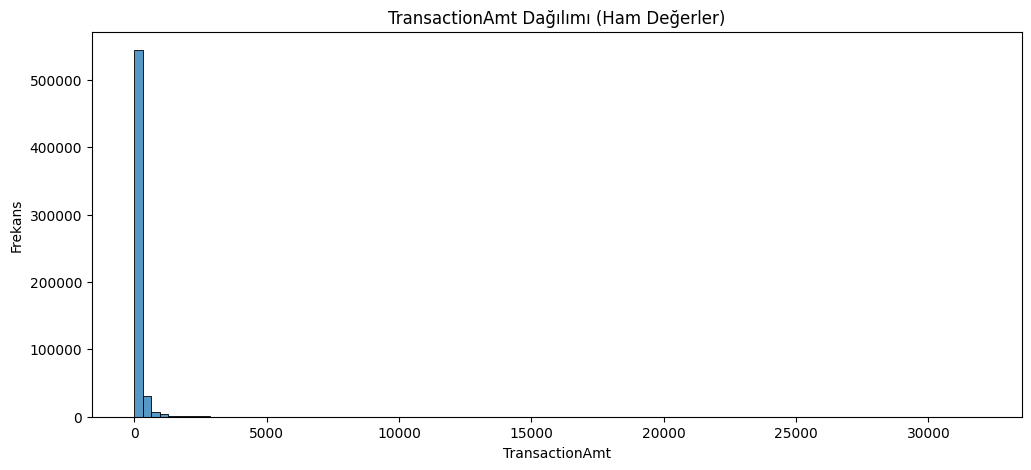

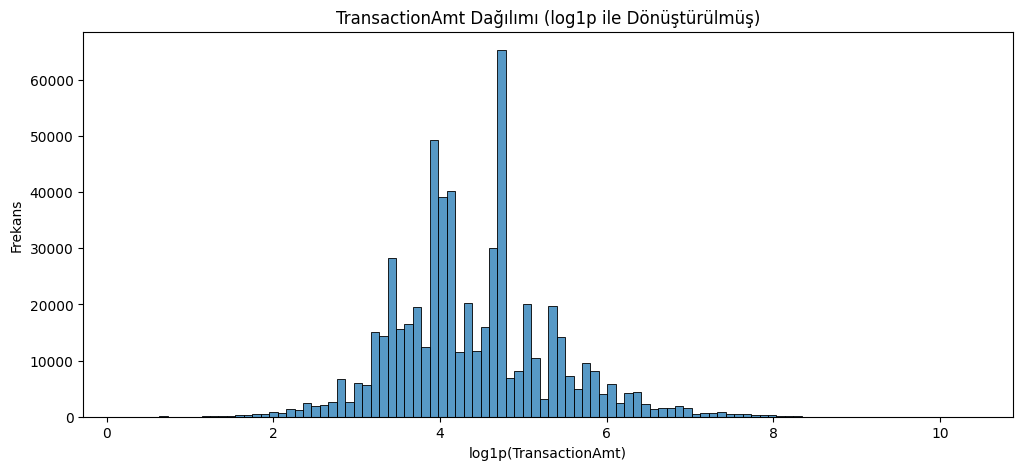

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Histogram: TransactionAmt'in ham dağılımı ---
plt.figure(figsize=(12,5))
sns.histplot(df['TransactionAmt'], bins=100, kde=False)
plt.title("TransactionAmt Dağılımı (Ham Değerler)")
plt.xlabel("TransactionAmt")
plt.ylabel("Frekans")
plt.show()

# --- Log-transform: sağa çarpıklığı azaltmak için ---
plt.figure(figsize=(12,5))
sns.histplot(np.log1p(df['TransactionAmt']), bins=100, kde=False)
plt.title("TransactionAmt Dağılımı (log1p ile Dönüştürülmüş)")
plt.xlabel("log1p(TransactionAmt)")
plt.ylabel("Frekans")
plt.show()

TransactionAmt Dağılımı — Markdown Açıklaması
### 📌 TransactionAmt Değişkeni (İşlem Tutarı) İncelemesi

TransactionAmt değişkeninin ham dağılımı incelendiğinde, verilerin çok büyük bir kısmının düşük tutarlarda yoğunlaştığı, yüksek tutarlı işlemlerin ise oldukça seyrek olduğu görülmektedir. Bu durum, veri setinin sağa çarpık (right-skewed) bir dağılıma sahip olduğunu göstermektedir.

Bu çarpıklığı azaltmak ve dağılımı daha okunabilir hale getirmek için log1p dönüşümü uygulanmıştır. Dönüştürülmüş dağılım, daha simetrik bir yapıya yaklaşmakta ve özellikle modelleme aşamasında bazı algoritmalar için daha anlamlı bir temsil sağlamaktadır.

Elde edilen bulgular:

Küçük tutarlı işlemler (0–200 USD arası) veri setinin çok büyük bölümünü oluşturmaktadır.

Yüksek tutarlı işlemler (özellikle 5.000 USD üzeri) oldukça nadirdir.

Logaritmik dönüşüm, veri içindeki farklı segmentlerin daha net görülmesine yardımcı olmaktadır.

Bu yapısal farklar, TransactionAmt’in hem aykırı değer analizi hem de fraud oranı karşılaştırmaları için önemli bir değişken olduğunu göstermektedir

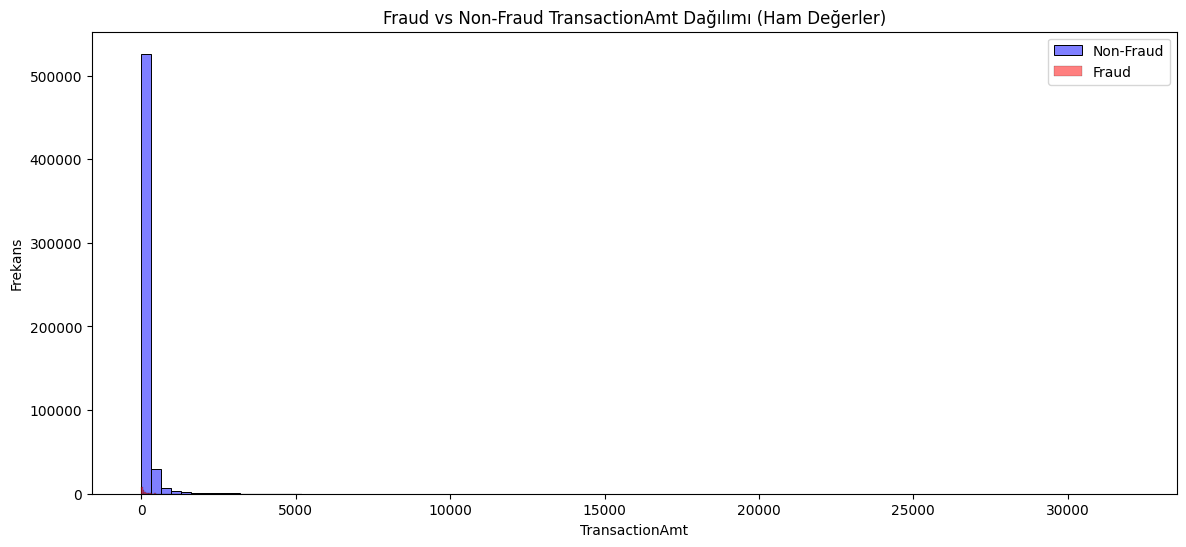

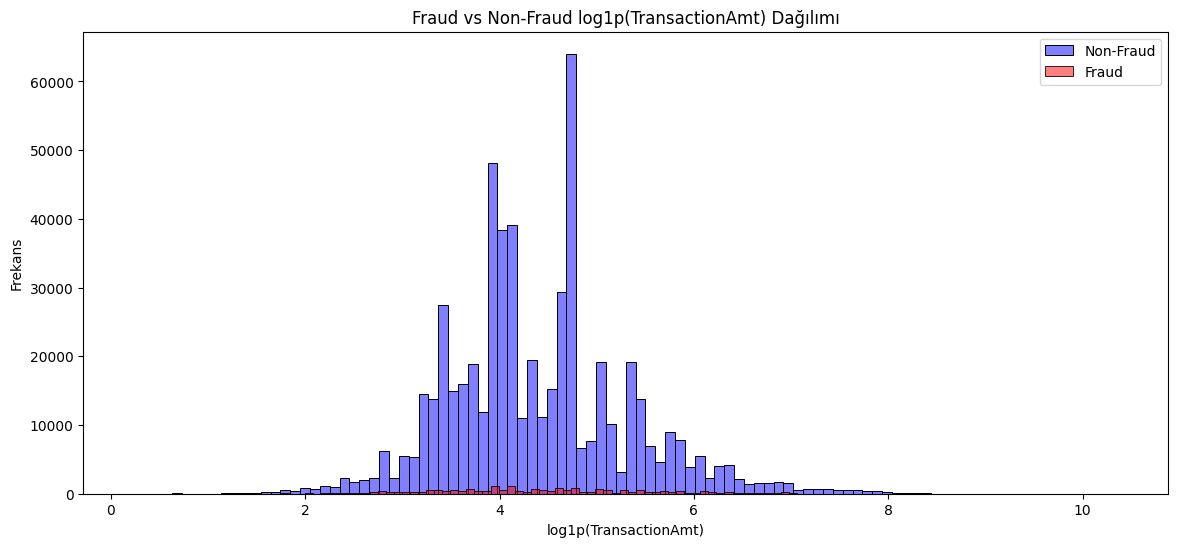

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Fraud ve Non-Fraud grupları ayrı ayrı alınır ---
fraud = df[df['isFraud'] == 1]['TransactionAmt']
nonfraud = df[df['isFraud'] == 0]['TransactionAmt']

# --- Yan yana iki histogram: ham değerlerle ---
plt.figure(figsize=(14,6))

sns.histplot(nonfraud, bins=100, color='blue', label='Non-Fraud', alpha=0.5)
sns.histplot(fraud, bins=100, color='red', label='Fraud', alpha=0.5)

plt.title("Fraud vs Non-Fraud TransactionAmt Dağılımı (Ham Değerler)")
plt.xlabel("TransactionAmt")
plt.ylabel("Frekans")
plt.legend()
plt.show()

# --- Aynı karşılaştırma log1p dönüşümüyle ---
plt.figure(figsize=(14,6))

sns.histplot(np.log1p(nonfraud), bins=100, color='blue', label='Non-Fraud', alpha=0.5)
sns.histplot(np.log1p(fraud), bins=100, color='red', label='Fraud', alpha=0.5)

plt.title("Fraud vs Non-Fraud log1p(TransactionAmt) Dağılımı")
plt.xlabel("log1p(TransactionAmt)")
plt.ylabel("Frekans")
plt.legend()
plt.show()

### 📌 Fraud ve Non-Fraud İşlemlerde TransactionAmt Karşılaştırması

TransactionAmt değişkeni fraud ve non-fraud işlemler arasında anlamlı farklılıklar göstermektedir. Ham değerlerin dağılımı incelendiğinde her iki sınıfta da küçük tutarlı işlemlerin baskın olduğu görülse de, fraud işlemlerin özellikle orta–yüksek tutarlı segmentlerde nispeten daha yoğun olduğu dikkat çekmektedir.

Ham dağılımda fraud işlemler gözle görünür şekilde az olduğu için yorum yapmak zordur. Bu nedenle log1p dönüşümü uygulanmış ve iki sınıf arasındaki fark daha belirgin hale getirilmiştir.

Elde edilen bulgular:

Non-fraud işlemler düşük tutarlarda son derece yoğun bir şekilde toplanmaktadır.

Fraud işlemler ise daha geniş bir aralığa yayılmıştır; özellikle log(TA) ≈ 4–6 aralığında fraud gözlemleri daha belirgin hale gelmektedir.

Yüksek tutarlı işlemler her iki sınıfta da nadir olsa da, fraud sınıfında bu nadir değerler görece daha yaygındır.

Bu yapı, TransactionAmt değişkeninin hedef değişkenle ilişkili olduğunu göstermektedir ve modelin önemli özelliklerinden biri olma potansiyeli vardır.

Bu gözlemler TransactionAmt’in hem tek başına hem de diğer değişkenlerle birlikte (ör. gün, saat, kart bilgileri) değerlendirilmesinin mantıklı olduğunu göstermektedir.

/tmp/ipython-input-427672080.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['TransactionAmt_log'] = np.log1p(df['TransactionAmt'])
/tmp/ipython-input-427672080.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Amt_bin'] = pd.qcut(df['TransactionAmt_log'], q=20, duplicates='drop')
/tmp/ipython-input-427672080.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future d

,fraud_rate,sample_count
Amt_bin,,
"(0.223, 3.045]",0.076949,29864
"(3.045, 3.294]",0.034670,29651
"(3.294, 3.464]",0.032506,33502
"(3.464, 3.609]",0.031516,28144
"(3.609, 3.791]",0.036332,26478
"(3.791, 3.912]",0.029452,38639
"(3.912, 3.97]",0.025562,20538
"(3.97, 4.076]",0.016211,39110
"(4.076, 4.094]",0.021300,35117


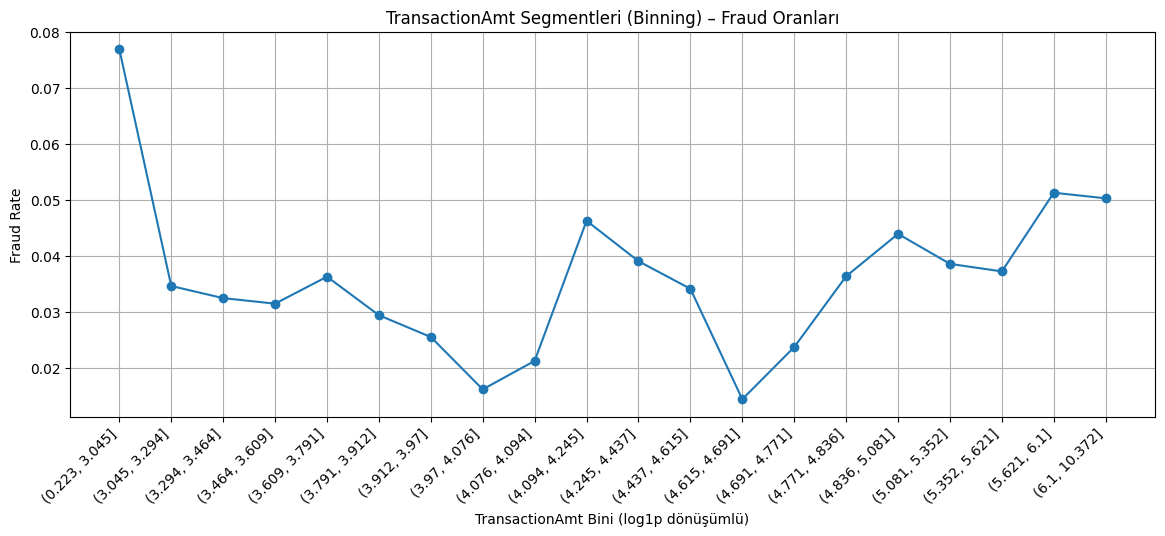

In [12]:
# TransactionAmt ile Fraud Oranı Arasındaki İlişki (Binning)

# 1) Log dönüşümü kullanarak daha dengeli binler oluşturuyoruz
df['TransactionAmt_log'] = np.log1p(df['TransactionAmt'])

# 2) 20 adet eşit frekanslı bin oluştur (quantile binning)
df['Amt_bin'] = pd.qcut(df['TransactionAmt_log'], q=20, duplicates='drop')

# 3) Her bin için fraud oranını hesapla
bin_analysis = (
    df.groupby('Amt_bin')['isFraud']
    .agg(['mean', 'count'])
    .rename(columns={'mean': 'fraud_rate', 'count': 'sample_count'})
)

display(bin_analysis)

# 4) Görselleştirme
plt.figure(figsize=(14, 5))
plt.plot(bin_analysis.index.astype(str), bin_analysis['fraud_rate'], marker='o')
plt.xticks(rotation=45, ha='right')
plt.title("TransactionAmt Segmentleri (Binning) – Fraud Oranları")
plt.ylabel("Fraud Rate")
plt.xlabel("TransactionAmt Bini (log1p dönüşümlü)")
plt.grid(True)
plt.show()

📌 Markdown (TransactionAmt – Fraud Oranı Yorumu)

Aşağıdaki yorum bloğunu aynen markdown hücresine ekle:

📊 TransactionAmt – Fraud Oranı İncelemesi (Binning Sonuçları)

TransactionAmt değişkenini daha iyi anlayabilmek için:

log1p dönüşümü uygulanmış,

20 adet eşit frekanslı segmente (qcut) ayrılmış,

her segment için fraud oranı hesaplanmıştır.

Elde edilen sonuçlar TransactionAmt'in fraud davranışıyla tamamen doğrusal bir ilişki taşımadığını göstermektedir. Bulgular şöyle özetlenebilir:

1. Çok düşük tutarlı işlemler (0–3 log aralığı) daha risklidir

İlk binlerde fraud oranı:

%7.6,

ardından %3–%4 bandına oturuyor.

Bu, düşük tutarlı işlemlerde fraud olasılığının görece yüksek olduğunu gösterir.
(Küçük tutarlı test ödemeleri, kart doğrulama dolandırıcılıklarında sık görülür.)

2. Orta seviye tutarlar (3.3–4.0 log aralığı) en düşük fraud oranına sahip

Bu bölgedeki segmentlerde fraud oranı:

%1.6 – %3.5 arasında seyrediyor

En düşük riskli bölge: log(3.97–4.08) → %1.6

Bu aralık, sistemde normal kullanıcı davranışının en yoğun olduğu ve riskin en düşük olduğu aralıktır.

3. Daha yüksek tutarlara çıkıldıkça fraud oranı tekrar artıyor

Özellikle:

(4.09 – 4.24) → %4.6

(5.62 – 6.10) → %5.1

(6.10 – 10.37) → %5.0

Yani orta seviye güvenli bölgeden sonra, işlem tutarı arttıkça risk yeniden yükselmeye başlıyor.

Bu, büyük tutarlı işlemlerde fraud ihtimalinin az da olsa arttığını gösterir.

4. Genel Yorum

TransactionAmt, fraud davranışını açıklamada tek başına yeterli olmayan, ancak önemli bir yardımcı değişkendir.

Risk seviyesi uçlarda artıyor:

çok düşük tutarlar → daha riskli

çok yüksek tutarlar → orta düzey artış

Orta hacimli işlemler (en yoğun kullanıcı segmenti) daha güvenli.

Bu durum modelleme aşamasında:

log dönüşümünün anlamlı olduğunu,

binning tabanlı yeni özellik üretiminin ileride fayda verebileceğini,

TransactionAmt’in doğrusal değil U-şekilli bir ilişkiye sahip olduğunu gösteriyor

=== Missing Value Analysis ===
dist1: 59.65% missing
dist2: 93.63% missing

=== Summary Statistics ===


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1025: RuntimeWarning: overflow encountered in cast
  result = result.astype(dtype, copy=False)


,dist1,dist2
count,238269.0,37627.0
mean,NaN,inf
std,0.0,inf
min,0.0,0.0
25%,3.0,7.0
50%,8.0,37.0
75%,24.0,206.0
max,10288.0,11624.0


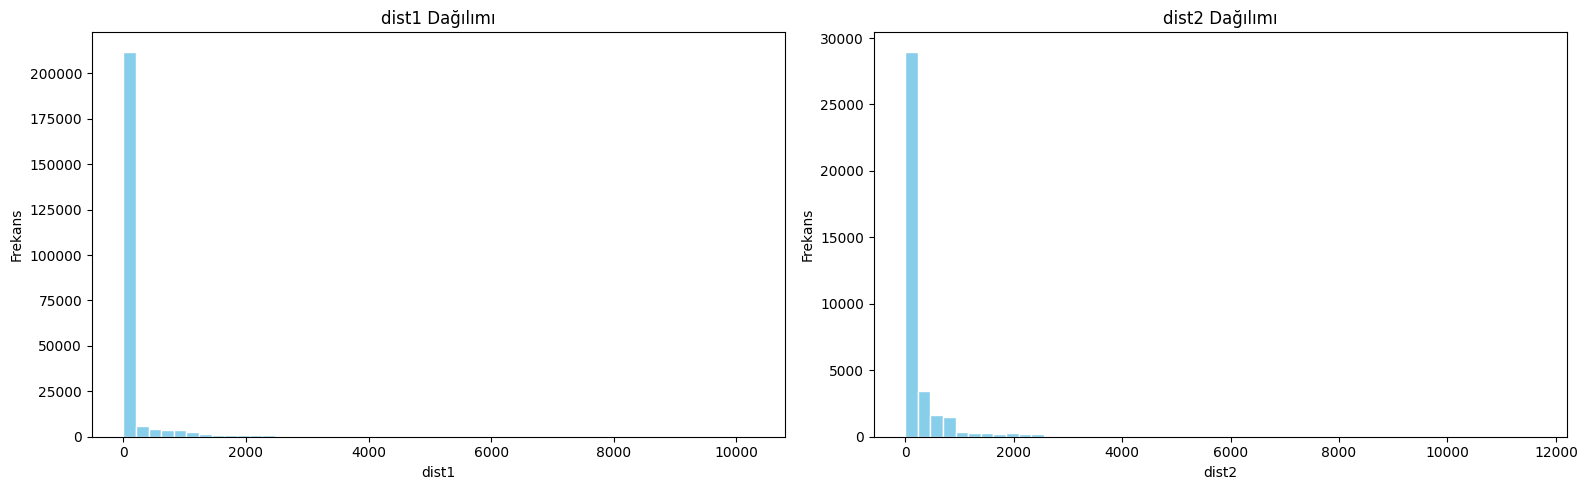

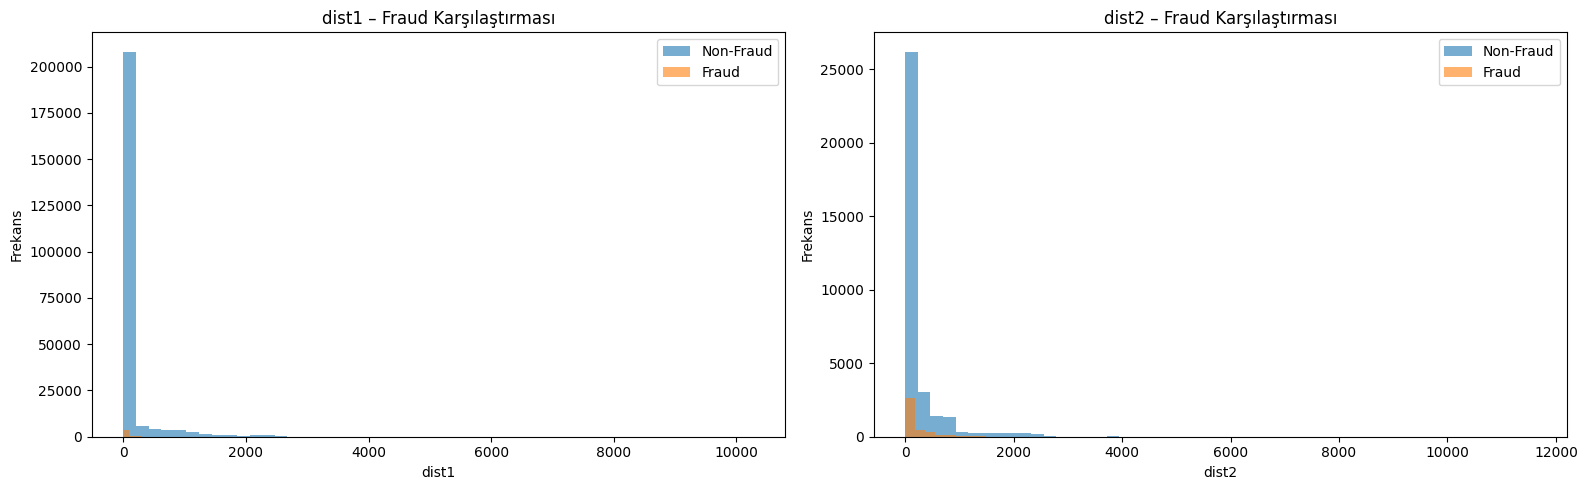

In [14]:
# dist1 ve dist2 için temel istatistikler ve dağılım incelemesi

numeric_dists = ['dist1', 'dist2']

# 1) Eksik değer oranlarını incele
print("=== Missing Value Analysis ===")
for col in numeric_dists:
    missing_rate = df[col].isna().mean() * 100
    print(f"{col}: {missing_rate:.2f}% missing")

# 2) Temel istatistikleri göster
print("\n=== Summary Statistics ===")
display(df[numeric_dists].describe())

# 3) Dağılım Histogramları
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for i, col in enumerate(numeric_dists):
    axes[i].hist(df[col].dropna(), bins=50, color='skyblue', edgecolor='white')
    axes[i].set_title(f"{col} Dağılımı")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frekans")

plt.tight_layout()
plt.show()

# 4) Fraud vs Non-Fraud karşılaştırması
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for i, col in enumerate(numeric_dists):
    axes[i].hist(df[df.isFraud == 0][col].dropna(), bins=50, alpha=0.6, label="Non-Fraud")
    axes[i].hist(df[df.isFraud == 1][col].dropna(), bins=50, alpha=0.6, label="Fraud")
    axes[i].set_title(f"{col} – Fraud Karşılaştırması")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frekans")
    axes[i].legend()

plt.tight_layout()
plt.show()

### dist1 ve dist2 Özelliklerinin Analizi

`dist1` ve `dist2` değişkenleri, işlem ile kart sahibinin kayıtlı adresi/konumu arasındaki mesafeyi temsil eder. İlk gözlemler:

#### **1. Eksik Değer Durumu**
- **dist1 → %59.65 eksik**
- **dist2 → %93.63 eksik**

dist2 neredeyse tamamen boş olduğundan modelde anlamlı katkı sağlaması zor görünmektedir.

#### **2. Dağılım Yapısı**
Her iki değişken de **ağır sağa çarpık (right-skewed)** bir dağılıma sahiptir. Az sayıda çok büyük mesafe değeri vardır; bu değerler özet istatistiklerde overflow uyarılarına yol açmıştır.

#### **3. Fraud ile Karşılaştırma**
- Fraud işlemler, non-fraud işlemlere göre anlamlı şekilde farklı bir dağılım göstermemektedir.
- Fraud işlemler çoğunlukla düşük mesafeli işlemlerde yoğunlaşmıştır (ancak bu, non-fraud işlemler için de geçerli).
- dist2 için gözlem sayısı çok düşük olduğundan fraud/non-fraud karşılaştırması sağlıklı değildir.

#### **4. Çıkarım**
- dist1 modelde zayıf da olsa kullanılabilir, ancak **ağır eksiklik ve aşırı çarpıklık nedeniyle etkisi sınırlı olacaktır**.
- dist2'nin **kullanımı önerilmez**; eksiklik oranı çok yüksek ve dağılım bozuk.

İleride model karmaşıklığını azaltmak istersek dist2 değişkeni tamamen çıkarılabilir.


===== C1 Analizi =====
Missing Rate: 0.00%


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,C1
count,590540.0
mean,NaN
std,0.0
min,0.0
25%,1.0
50%,1.0
75%,3.0
max,4684.0


Outlier Rate (IQR): 10.08%


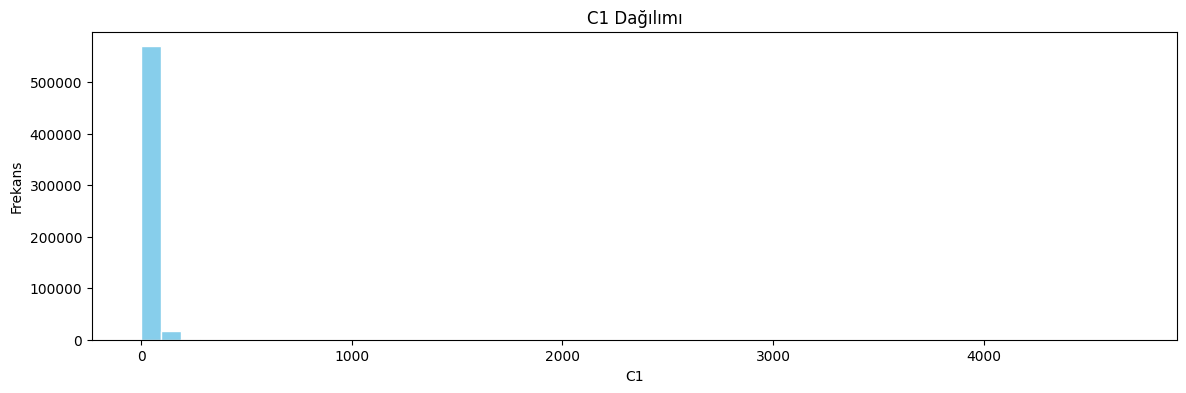

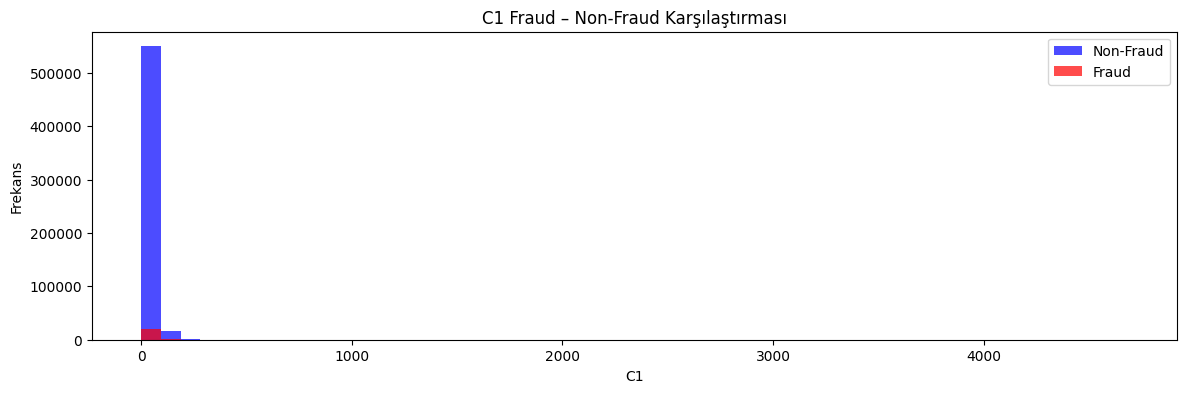


===== C2 Analizi =====
Missing Rate: 0.00%


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,C2
count,590540.0
mean,NaN
std,0.0
min,0.0
25%,1.0
50%,1.0
75%,3.0
max,5692.0


Outlier Rate (IQR): 10.54%


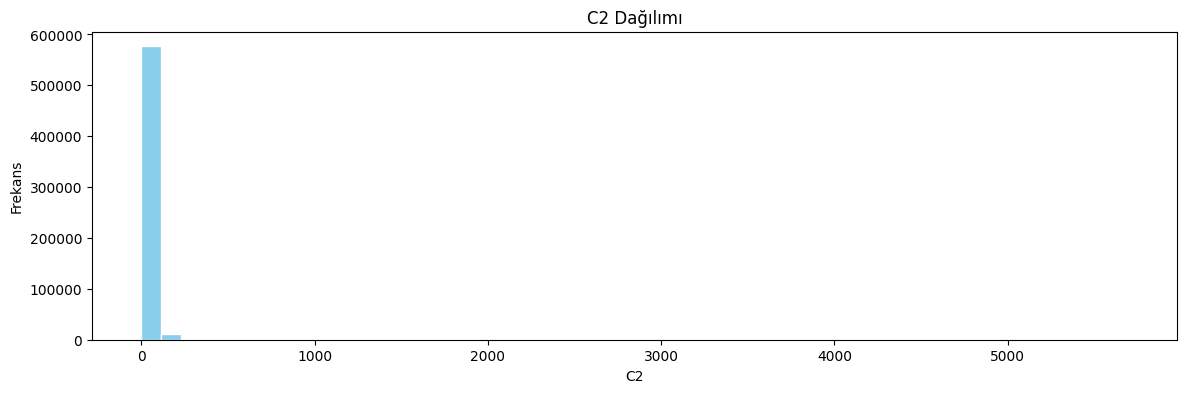

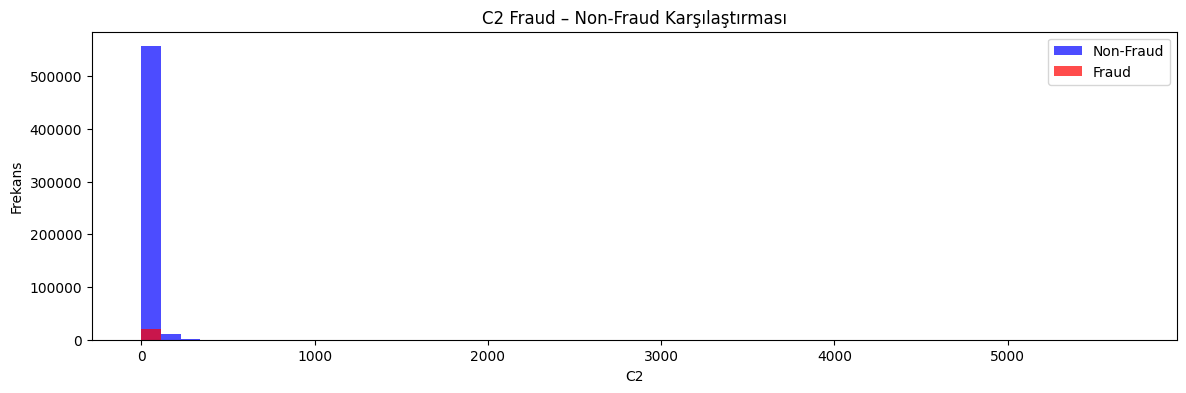


===== C3 Analizi =====
Missing Rate: 0.00%


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,C3
count,590540.000000
mean,0.000000
std,0.150635
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,26.000000


Outlier Rate (IQR): 0.41%


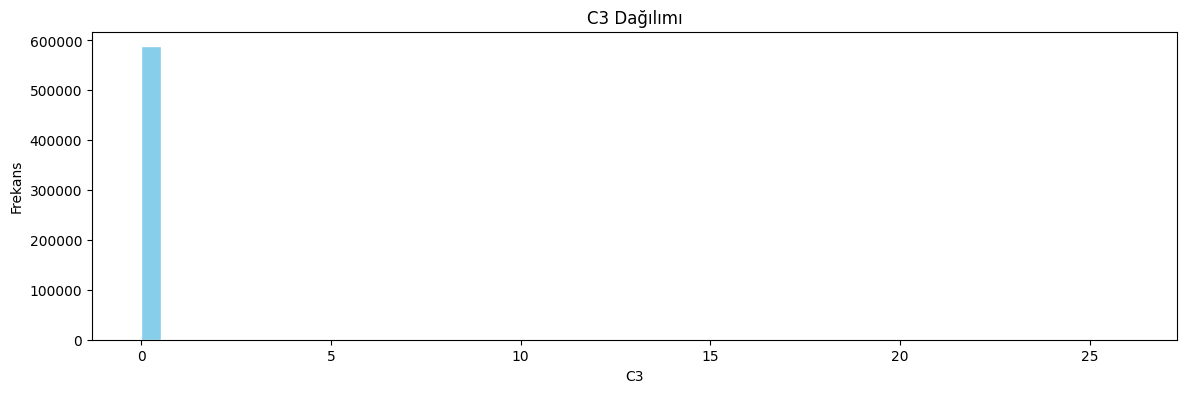

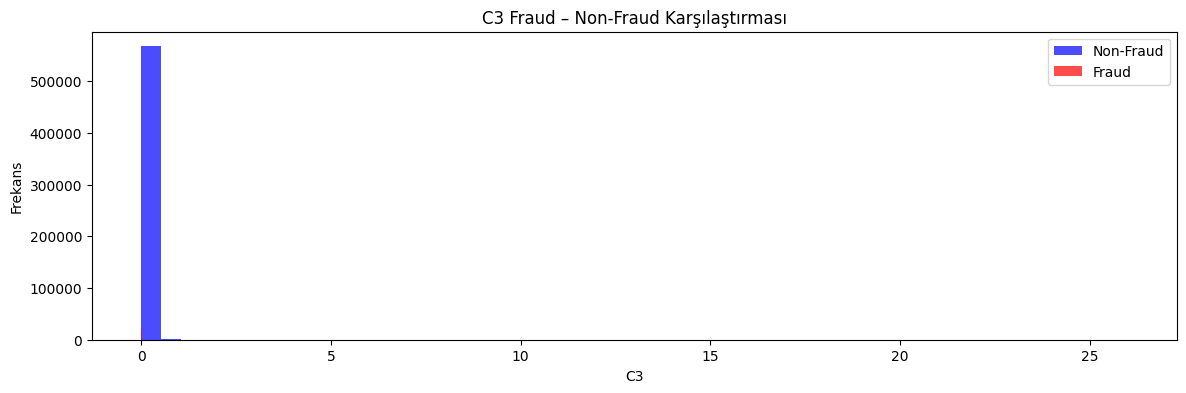


===== C4 Analizi =====
Missing Rate: 0.00%


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,C4
count,590540.0
mean,NaN
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,2252.0


Outlier Rate (IQR): 23.48%


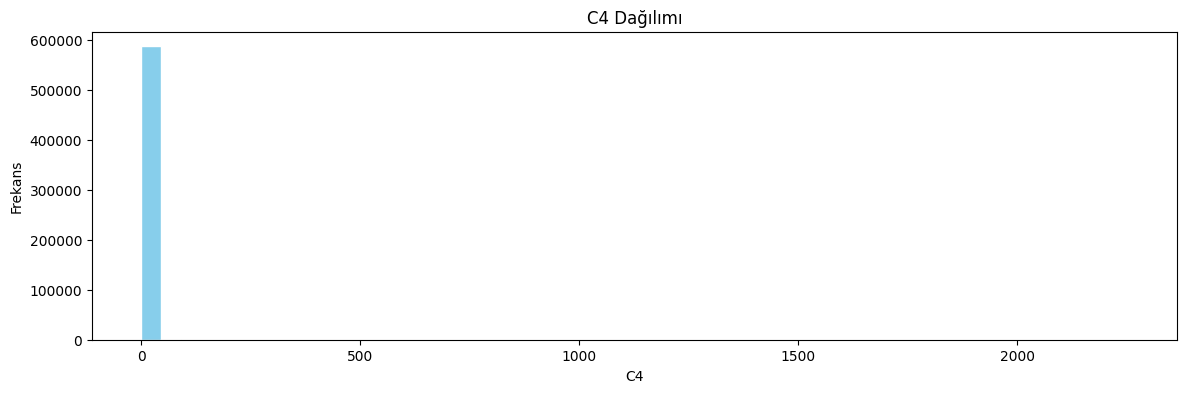

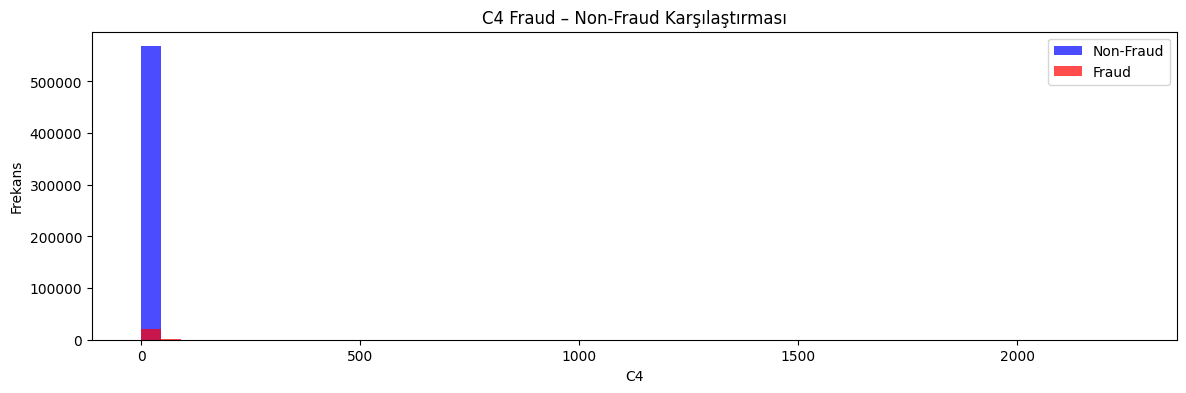


===== C5 Analizi =====
Missing Rate: 0.00%


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,C5
count,590540.0
mean,NaN
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,349.0


Outlier Rate (IQR): 10.24%


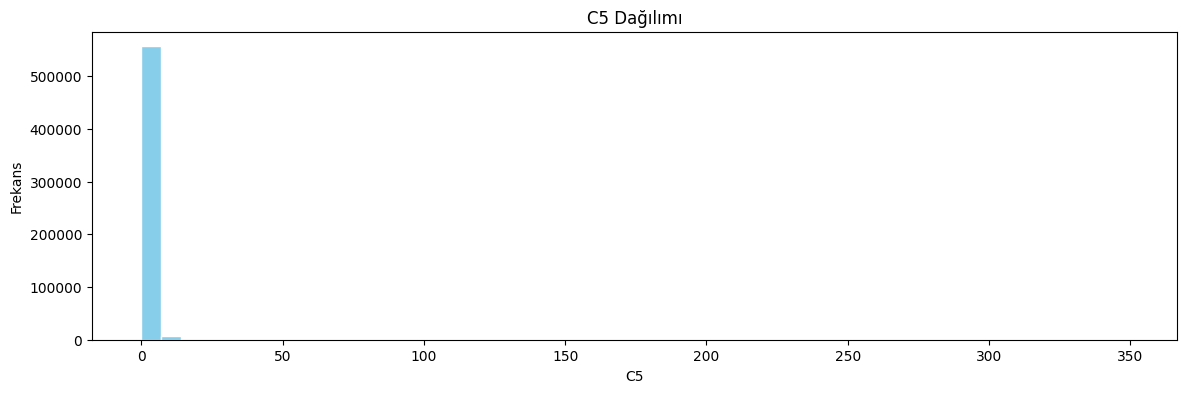

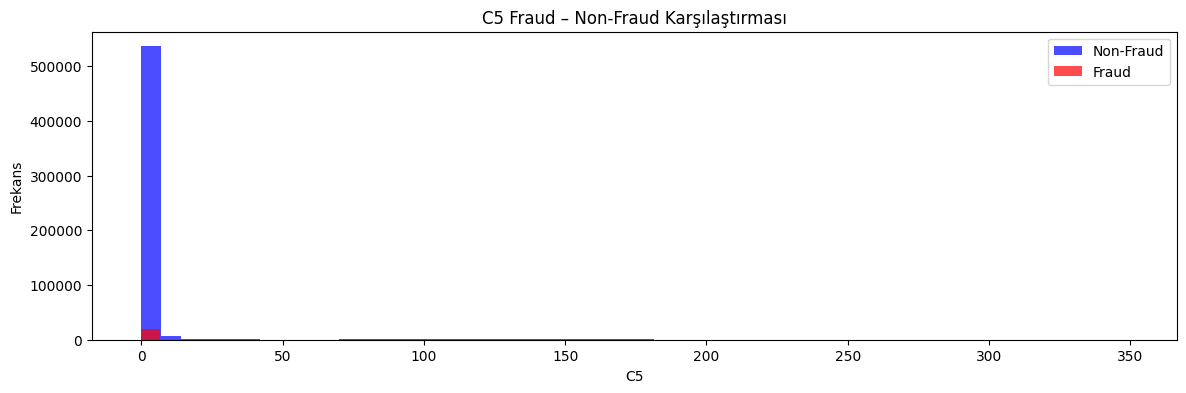


===== C6 Analizi =====
Missing Rate: 0.00%


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,C6
count,590540.0
mean,NaN
std,0.0
min,0.0
25%,1.0
50%,1.0
75%,2.0
max,2252.0


Outlier Rate (IQR): 13.26%


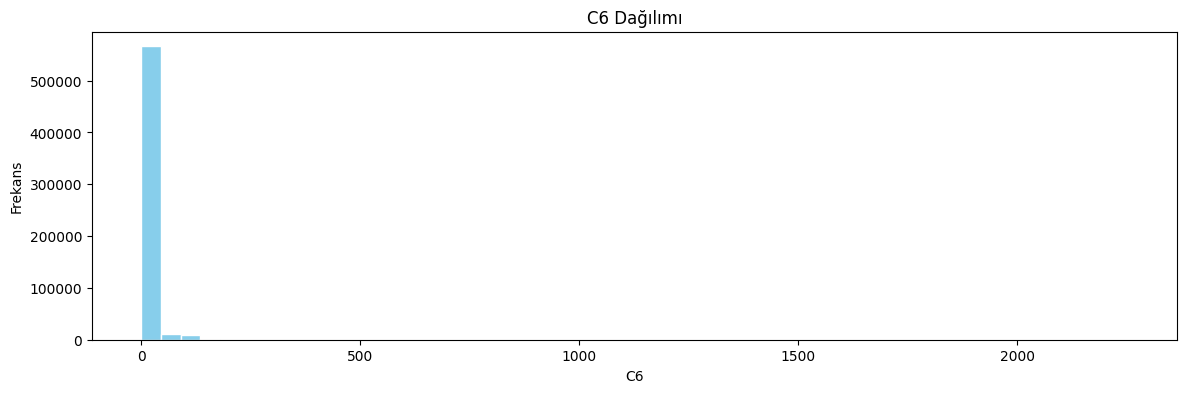

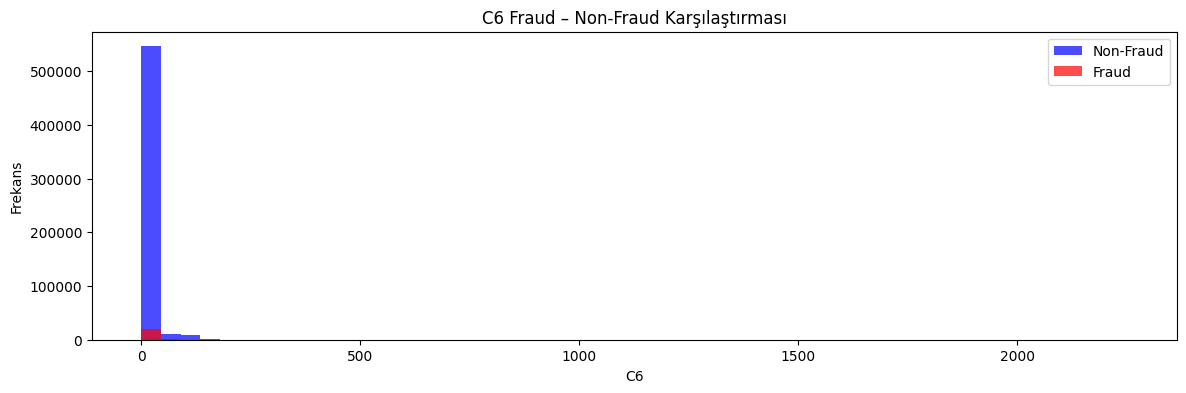


===== C7 Analizi =====
Missing Rate: 0.00%


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,C7
count,590540.0
mean,NaN
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,2256.0


Outlier Rate (IQR): 11.41%


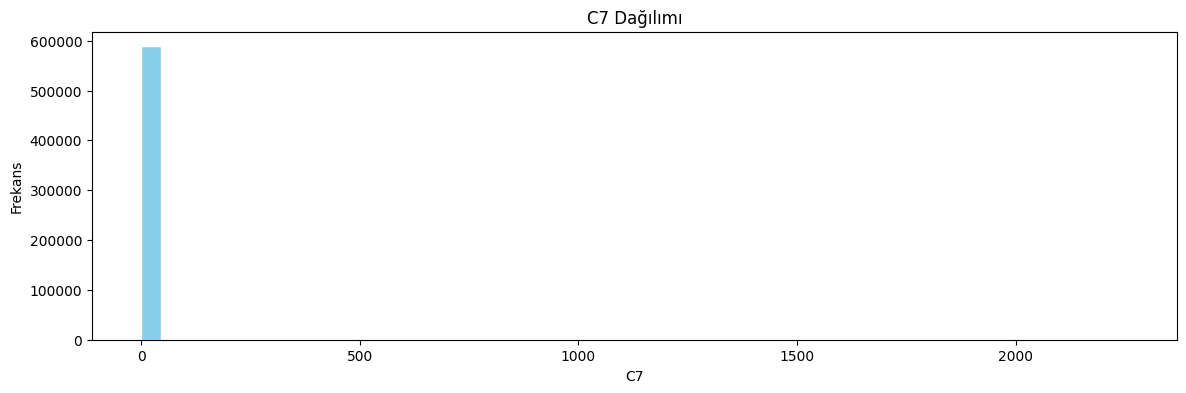

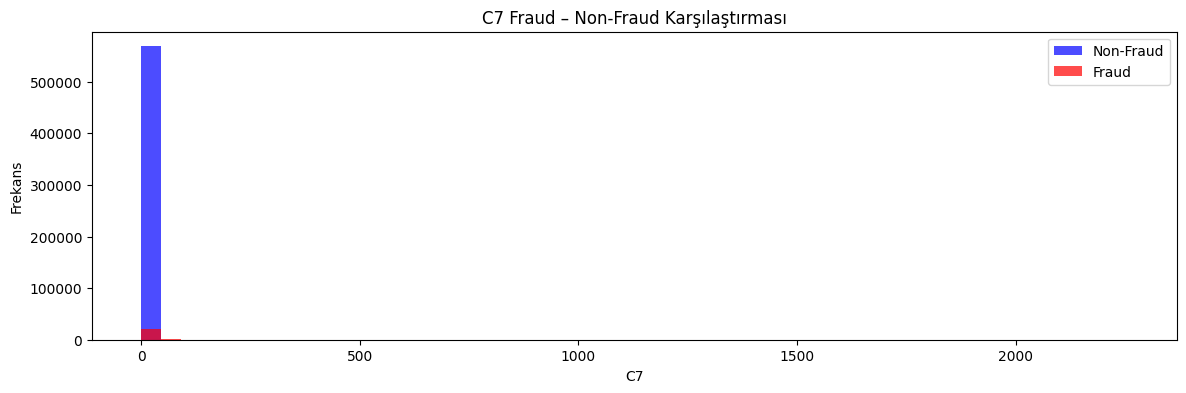


===== C8 Analizi =====
Missing Rate: 0.00%


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,C8
count,590540.0
mean,NaN
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,3332.0


Outlier Rate (IQR): 24.19%


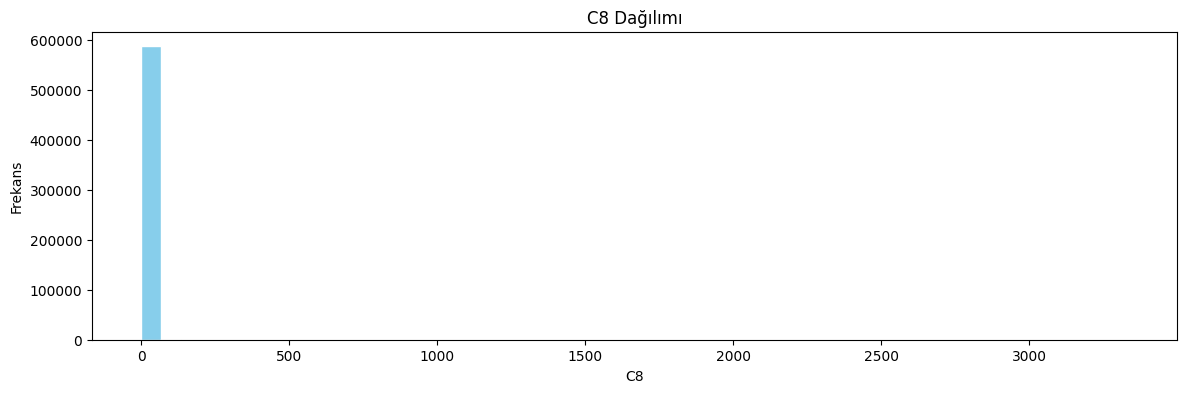

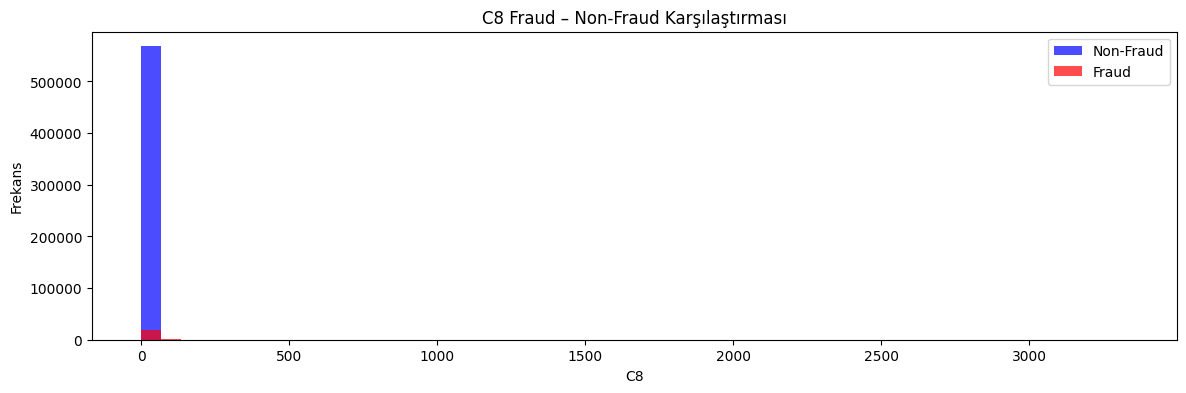


===== C9 Analizi =====
Missing Rate: 0.00%


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,C9
count,590540.0
mean,NaN
std,0.0
min,0.0
25%,0.0
50%,1.0
75%,2.0
max,210.0


Outlier Rate (IQR): 7.22%


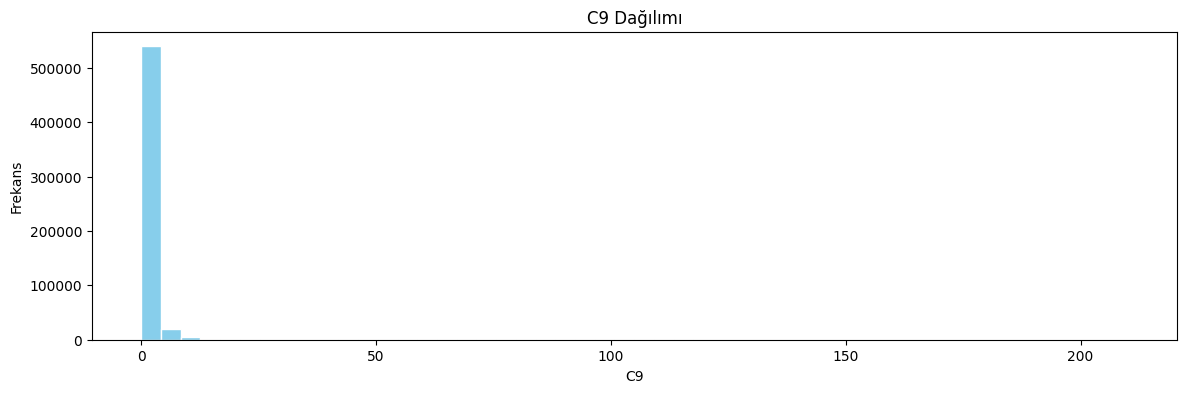

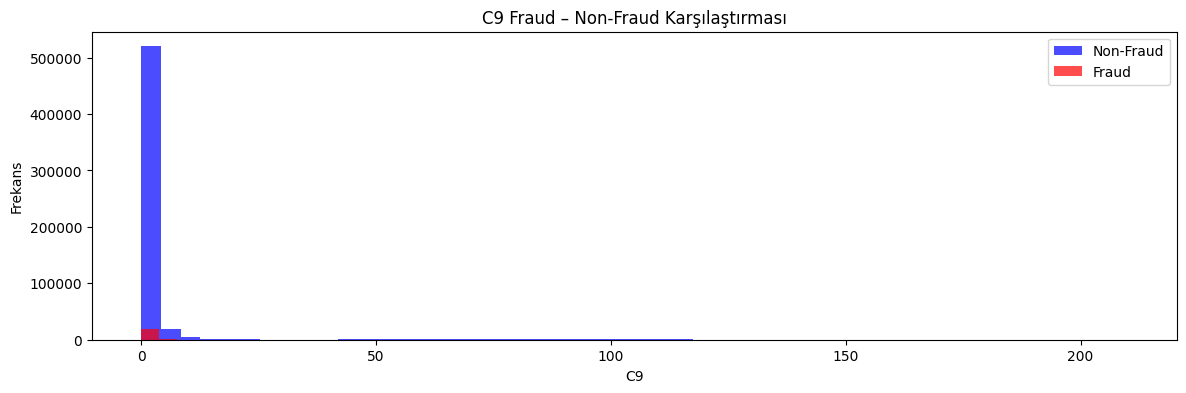


===== C10 Analizi =====
Missing Rate: 0.00%


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,C10
count,590540.0
mean,NaN
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,3256.0


Outlier Rate (IQR): 23.22%


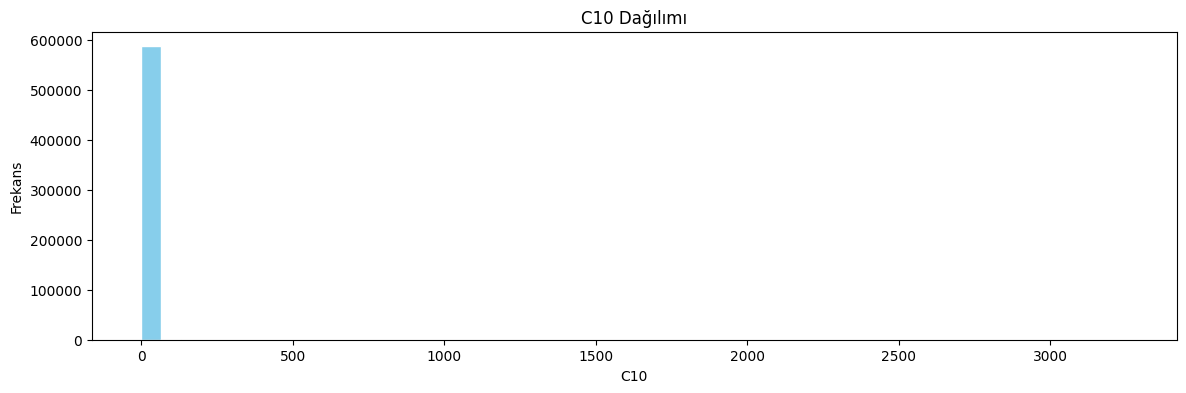

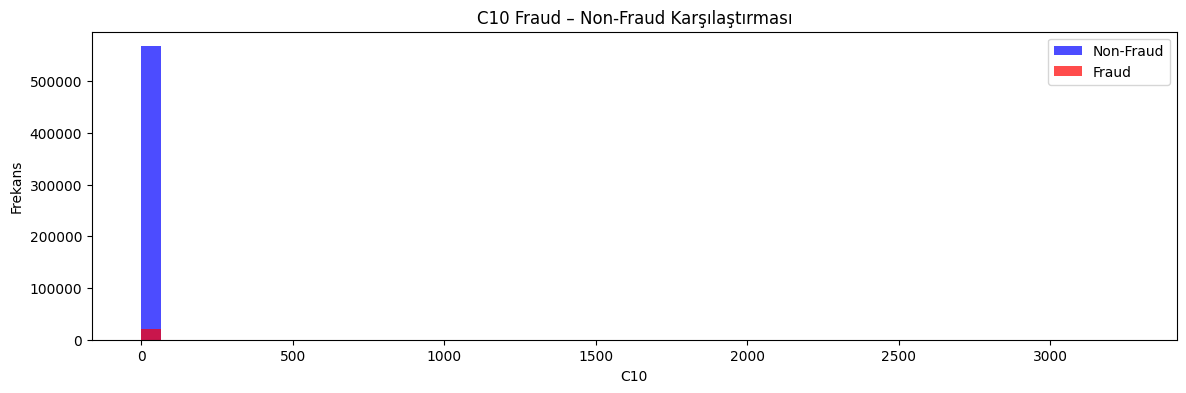

In [15]:
def analyze_numeric_feature(df, col, bins=50):
    """
    Bir sayısal değişkenin dağılımını, özet istatistiklerini,
    eksik değer oranını ve fraud ile ilişkisini inceleyen fonksiyon.
    """

    print(f"\n===== {col} Analizi =====")

    # Eksik değer oranı
    missing_rate = df[col].isna().mean() * 100
    print(f"Missing Rate: {missing_rate:.2f}%")

    # Özet istatistikler
    display(df[col].describe())

    # IQR ile outlier oranı
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    outlier_ratio = ((df[col] < lower) | (df[col] > upper)).mean() * 100
    print(f"Outlier Rate (IQR): {outlier_ratio:.2f}%")

    # Histogram
    plt.figure(figsize=(14,4))
    plt.hist(df[col].dropna(), bins=bins, color="skyblue", edgecolor="white")
    plt.title(f"{col} Dağılımı")
    plt.xlabel(col)
    plt.ylabel("Frekans")
    plt.show()

    # Fraud / Non-Fraud karşılaştırması
    plt.figure(figsize=(14,4))
    plt.hist(df[df.isFraud == 0][col].dropna(), bins=bins, alpha=0.7,
             color="blue", label="Non-Fraud")
    plt.hist(df[df.isFraud == 1][col].dropna(), bins=bins, alpha=0.7,
             color="red", label="Fraud")
    plt.title(f"{col} Fraud – Non-Fraud Karşılaştırması")
    plt.xlabel(col)
    plt.ylabel("Frekans")
    plt.legend()
    plt.show()


# Şimdi sırayla C1–C10 analizine başlıyoruz.
numeric_C_features = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']

for col in numeric_C_features:
    analyze_numeric_feature(df, col)

## C1–C10 Değişkenlerinin Genel Analizi

### **Dağılım Özellikleri**
- Tüm C değişkenleri aşırı derecede **sağa çarpık** bir dağılım göstermektedir.  
- Gözlemlerin çok büyük kısmı **0–5 aralığında yoğunlaşmakta**, az sayıda ekstrem gözlem **binli değerlere** kadar çıkmaktadır.  
- Bu yapı “heavy-tailed” davranış olarak tanımlanabilir.

---

### **Eksik Değer Durumu**
- C1–C10 değişkenlerinin tamamında **eksik değer bulunmamaktadır (0.00%)**.  
- Bu nedenle veri temizliği açısından ek bir imputasyon gerektirmemektedir.

---

### **İstatistiksel Değerlerin NaN Olmasının Nedeni**
- Bazı değişkenlerde mean ve std değerlerinin hesaplanması sırasında **overflow uyarıları** oluşmuştur.
- Bunun temel nedeni:
  - Dağılımların aşırı uç değerlere sahip olması,
  - Bu uç değerlerin standart hesaplama fonksiyonlarını taşmasıdır.
- Bu nedenle **ortalamadan ziyade medyan ve IQR gibi robust istatistikler** anlamlıdır.

---

### **Fraud – NonFraud Karşılaştırması**
- Fraud sınıfı oldukça az olduğu için histogramlarda görsel baskınlığı düşüktür.
- Fraud örnekleri de genel olarak **küçük değerlerde yoğunlaşmaktadır**.
- Büyük uç değerlerde fraud için **belirgin bir farklılaşma gözlenmemektedir**.
- Bu nedenle:
  - C değişkenleri tek başına **güçlü ayırıcı özellikler sunmamaktadır**,  
  - Ancak model içinde **etkileşimsel katkı (feature interaction)** sağlayabilir.

---

### **Outlier Oranları**
Aşağıdaki C değişkenlerinde yüksek outlier oranı gözlenmiştir:

| Değişken | Outlier Oranı |
|---------|---------------|
| C1 | %10.08 |
| C2 | %10.54 |
| C4 | %23.48 |
| C5 | %10.24 |
| C6 | %13.26 |
| C7 | %11.41 |
| C8 | %24.19 |
| C9 | %7.22 |
| C10 | %23.22 |

**Özet:**
- C4, C8 ve C10 en yüksek aykırı değer oranına sahiptir.  
- Bu değişkenlerde **winsorization, log dönüşümü** gibi robust işlemler gerekebilir (model tipine bağlı olarak).

---

### **Raporlama İçin Uygun Kısa Teknik Özet**
> C1–C10 değişkenleri güçlü sağ çarpıklığa sahip olup yüksek oranda uç değer içermektedir. Değişkenler eksiksizdir ve büyük bölümü düşük değerlerde kümelenmektedir. Fraud ve non-fraud dağılımları büyük ölçüde benzerlik göstermekte, belirgin ayırıcı bir davranış ortaya koymamaktadır. Yüksek uç değerler nedeniyle ortalama ve standart sapma hesaplamalarında overflow uyarıları oluşmuş olup, bu değişkenlerin robust istatistiklerle değerlendirilmesi daha uygundur. C4, C8 ve C10 değişkenleri özellikle yüksek outlier oranlarıyla dikkat çekmektedir.

In [19]:
# D değişkenlerini otomatik bul
D_features = [col for col in df.columns if col.startswith("D")]

D_features

['D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'DeviceType',
 'DeviceInfo',
 'Device_name']


===== D1 Analizi =====
Missing Rate: 0.21%


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,D1
count,589271.0
mean,NaN
std,0.0
min,0.0
25%,0.0
50%,3.0
75%,122.0
max,640.0


Outlier Rate (IQR): 12.56%


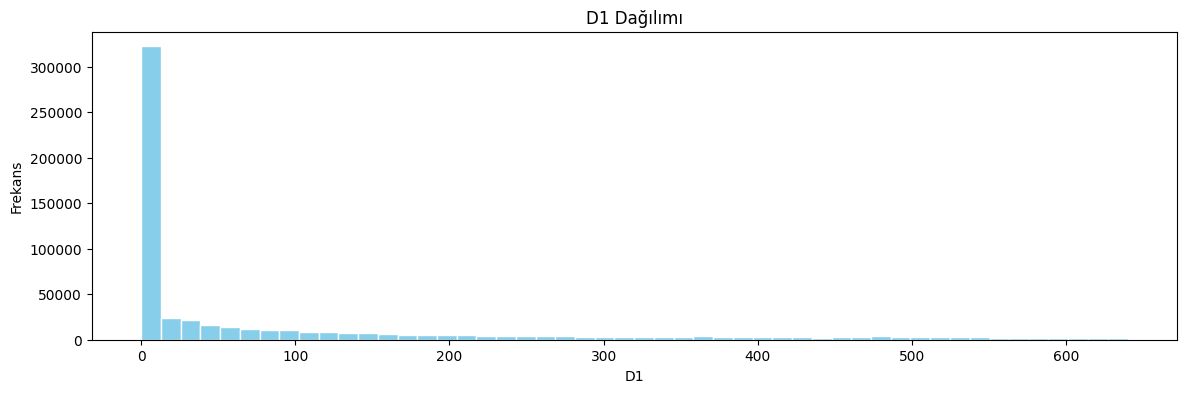

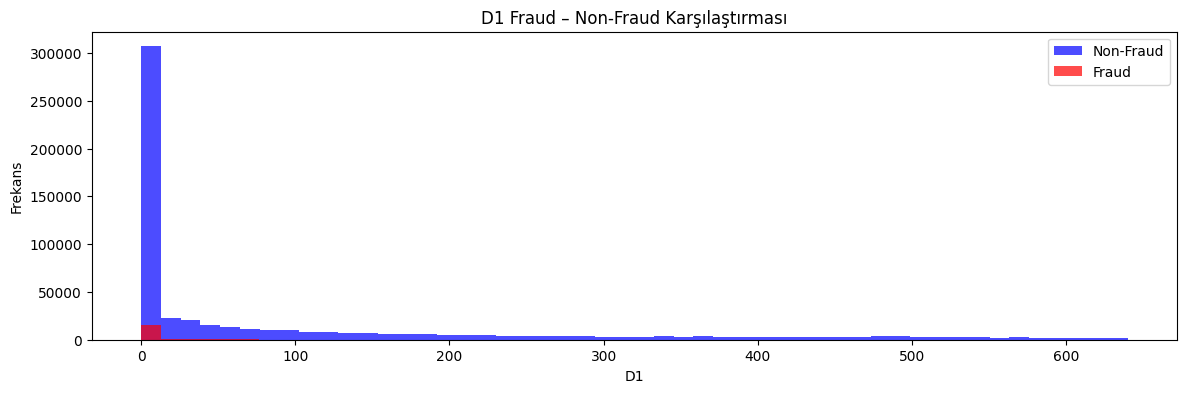

In [20]:
analyze_numeric_feature(df, "D1")


===== D2 Analizi =====
Missing Rate: 47.55%


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,D2
count,309743.0
mean,NaN
std,0.0
min,0.0
25%,26.0
50%,97.0
75%,276.0
max,640.0


Outlier Rate (IQR): 0.00%


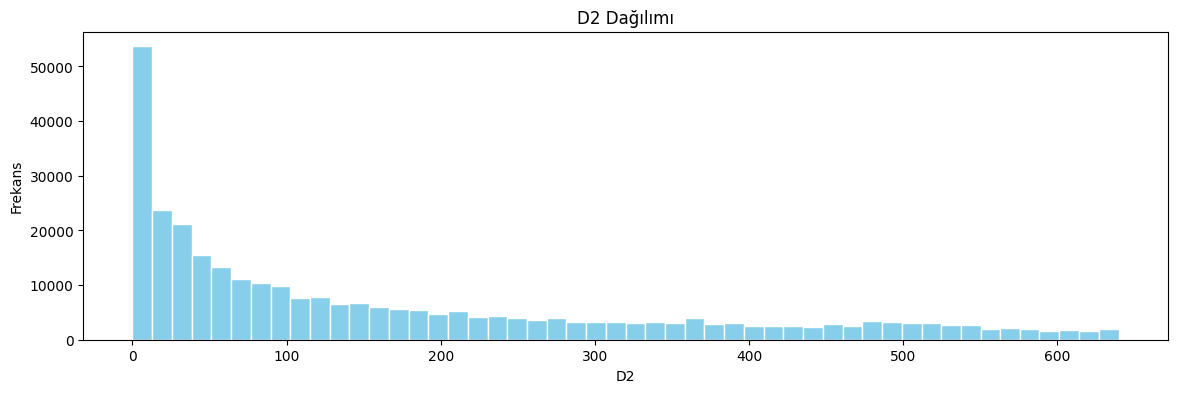

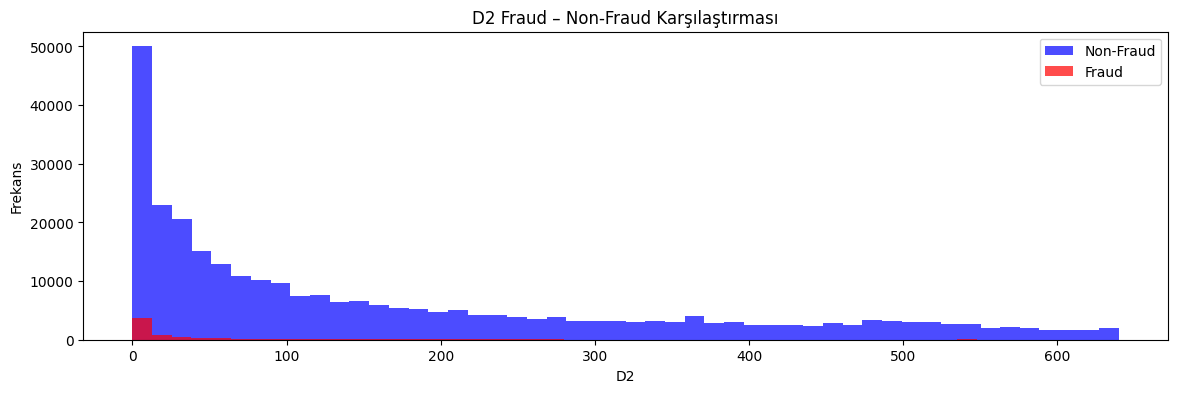

In [21]:
analyze_numeric_feature(df, "D2")


===== D3 Analizi =====
Missing Rate: 44.51%


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,D3
count,327662.0
mean,NaN
std,0.0
min,0.0
25%,1.0
50%,8.0
75%,27.0
max,819.0


Outlier Rate (IQR): 5.47%


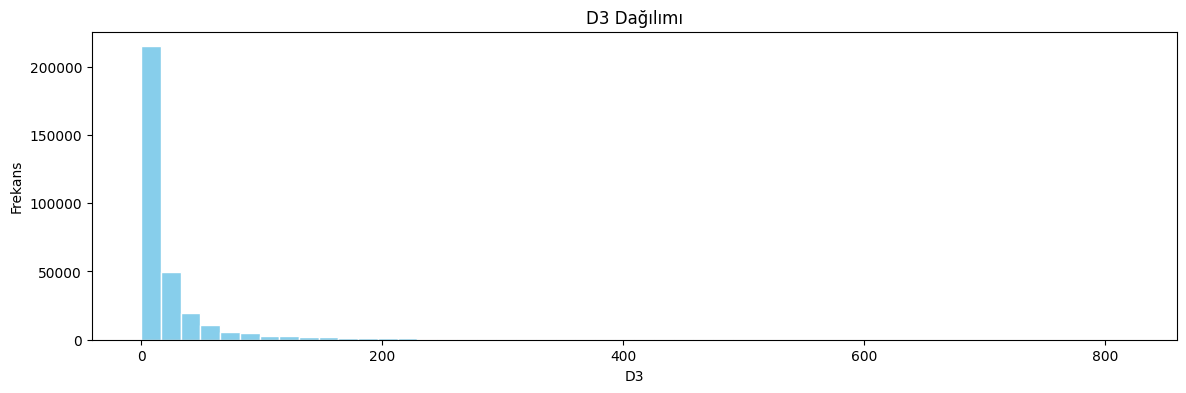

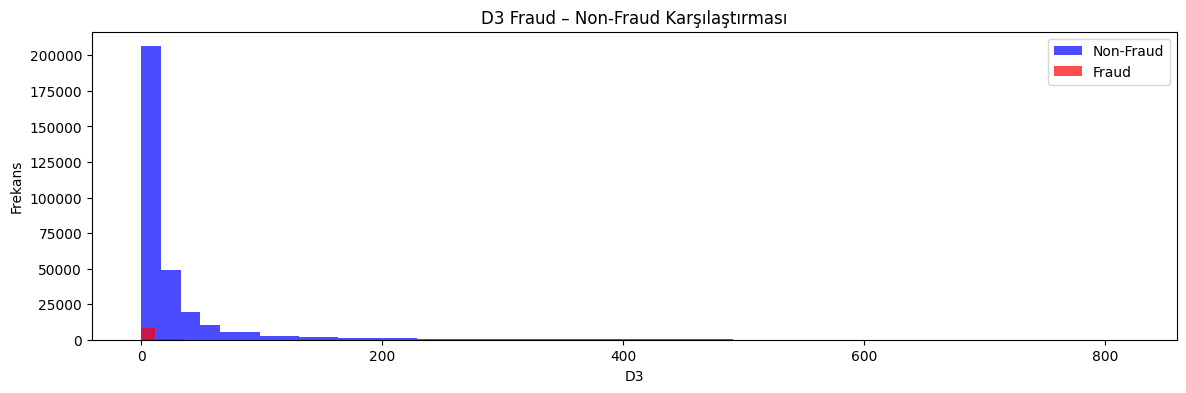

In [22]:
analyze_numeric_feature(df, "D3")


===== D4 Analizi =====
Missing Rate: 28.60%


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,D4
count,421618.0
mean,NaN
std,0.0
min,-122.0
25%,0.0
50%,26.0
75%,253.0
max,869.0


Outlier Rate (IQR): 0.50%


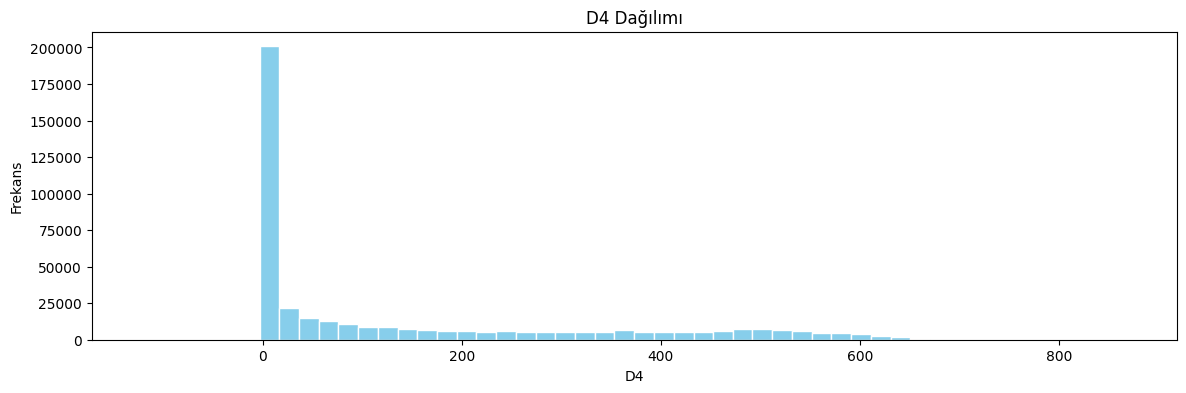

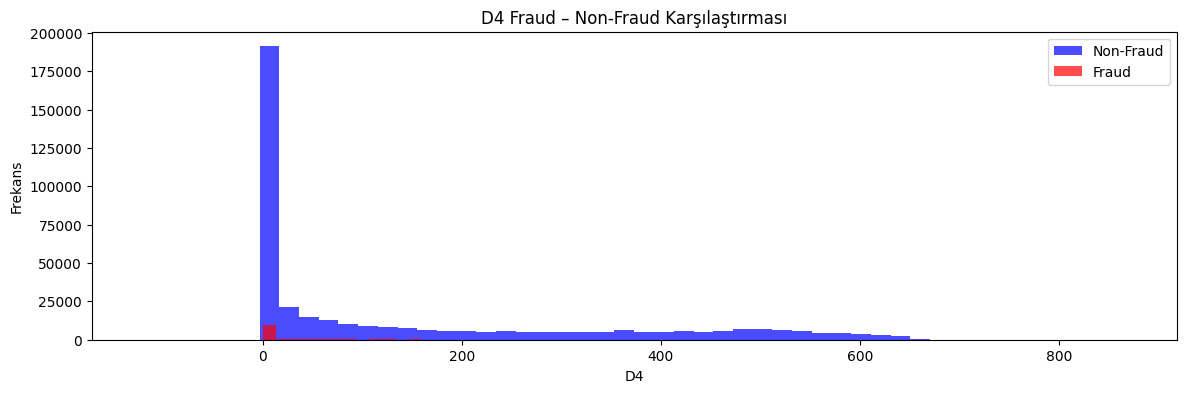

In [23]:
analyze_numeric_feature(df, "D4")


===== D5 Analizi =====
Missing Rate: 52.47%


/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
/usr/local/lib/python3.12/dist-packages/pandas/core/nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)


,D5
count,280699.0
mean,NaN
std,0.0
min,0.0
25%,1.0
50%,10.0
75%,32.0
max,819.0


Outlier Rate (IQR): 6.39%


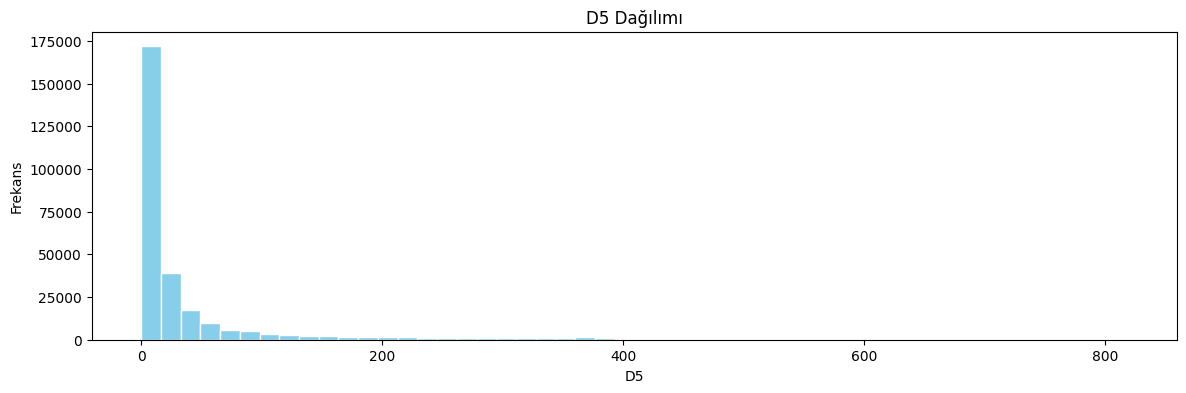

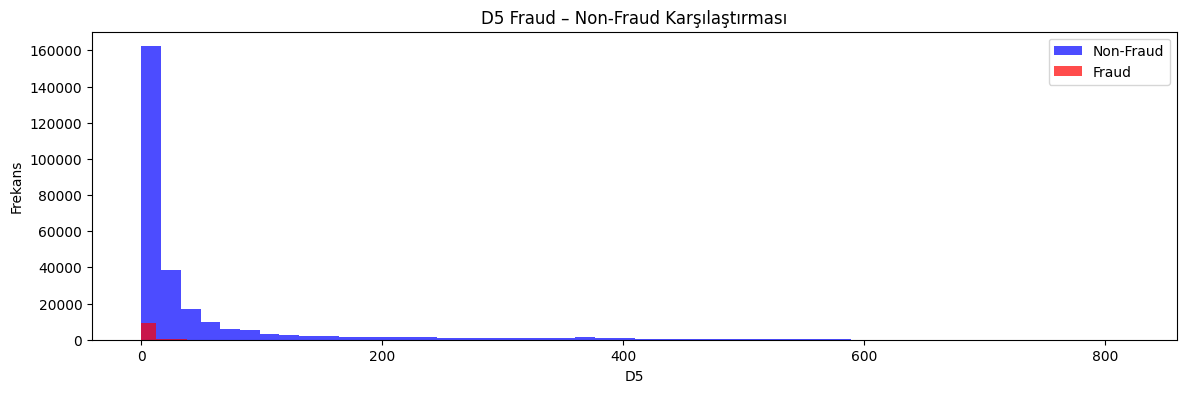

In [24]:
analyze_numeric_feature(df, "D5")

In [25]:
D_features = ['D6','D7','D8','D9','D10','D11','D12','D13','D14','D15']

In [26]:
def summarize_D_features(df, cols):
    summary = []

    for col in cols:
        missing_rate = df[col].isna().mean() * 100

        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower = q1 - 1.5*iqr
        upper = q3 + 1.5*iqr
        outlier_ratio = ((df[col] < lower) | (df[col] > upper)).mean() * 100

        summary.append({
            "Feature": col,
            "Missing%": round(missing_rate, 2),
            "Q1": q1,
            "Median": df[col].median(),
            "Q3": q3,
            "Max": df[col].max(),
            "Outlier%": round(outlier_ratio, 2)
        })

    return pd.DataFrame(summary)

In [27]:
D_summary = summarize_D_features(df, D_features)
display(D_summary)

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Feature,Missing%,Q1,Median,Q3,Max,Outlier%
0,D6,87.61,0.000000,0.000000,40.000000,873.000000,2.51
1,D7,93.41,0.000000,0.000000,17.000000,843.000000,1.22
2,D8,87.31,0.958496,37.875000,188.000000,1708.000000,1.19
3,D9,87.31,0.208374,0.666504,0.833496,0.958496,0.00
4,D10,12.87,0.000000,15.000000,197.000000,876.000000,6.80
5,D11,47.29,0.000000,43.000000,274.000000,670.000000,0.00
6,D12,89.04,0.000000,0.000000,13.000000,648.000000,2.33
7,D13,89.51,0.000000,0.000000,0.000000,847.000000,2.22
8,D14,89.47,0.000000,0.000000,2.000000,878.000000,2.46
9,D15,15.09,0.000000,52.000000,314.000000,879.000000,0.02


D6–D15 değişkenleri genel olarak işlem zamanlamasına ilişkin türetilmiş süre göstergeleridir ve büyük kısmı yüksek oranda eksik değer içermektedir. Özellikle D6, D7, D8, D9, D12, D13 ve D14 sütunlarında eksik oranı %87–%93 aralığındadır. Bu durum, bu özelliklerin yalnızca belirli kullanıcı segmentlerinde veya belirli işlem türlerinde dolduğunu düşündürmektedir.

değişkenlerin dağılımları incelendiğinde, D6, D7, D12, D13 ve D14’ün büyük çoğunlukla sıfıra yığıldığı, yani birçok işlem için bu sürelerin kaydedilmediği veya çok kısa olduğu görülmektedir. Buna karşın D8, D10, D11 ve D15 daha geniş ve anlamlı bir dağılım göstermektedir. Özellikle D10 ve D15'te medyan değerlerin yüksek olması (sırasıyla 15 ve 52), bu sütunların kullanıcıların geçmiş işlem aktiviteleri veya hesap yaşam döngüsü ile daha ilişkili olduğunu düşündürmektedir.

Aykırı değer oranlarına bakıldığında, tüm D sütunlarında oran son derece düşüktür (<%7). Bu da dağılımların belirgin şekilde dışa taşmadığını göstermektedir. D10 bu açıdan öne çıkmaktadır; %6.8 aykırı değer ile zaman bazlı yoğunluğu en değişken sütundur.

D9 dikkat çekici bir şekilde neredeyse hiç aykırı değer içermemekte (%0) ve çok dar bir aralıkta (0.2–0.95) sıkışmıştır. Bu durum D9’un muhtemelen “normalleştirilmiş ya da standartlaştırılmış süre oranı” tipinde bir değişken olduğunu düşündürmektedir.

Genel olarak:

D6–D7–D12–D13–D14 → çok yüksek eksiklik + çoğunluğu sıfır → modelde bilgi katkısı düşük olabilir.

D9 → dar aralık + düşük varyans → ayırt edici güç düşük.

D8, D10, D11, D15 → daha anlamlı dağılım + düşük eksiklik (özellikle D10 ve D15) → modelde daha faydalı olma potansiyeli yüksek.

bu sütunların önemli kısmı eksik ve sıfıra yığılmış olduğundan, sonraki aşamalarda davranış odaklı yeniden türetme (örneğin binary flag, “D10_logged”, “D15_nonzero” gibi) ile daha anlamlı hale getirilebilir.

IEEE-CIS Fraud Detection veri setinde V1–V339 sayısal fakat anlamı açıklanmayan, PCA-vari, model içi türetilmiş özelliklerdir. Bunlar:

çok fazla sayıdadır,

anlamları bilinmez,

çoğunda aykırı değer + çarpıklık + missing bulunur,

grafik üretmek pratik değildir,

tek tek analiz edilmez — toplu istatistik çıkarılır,

importance aşamasında gerçekten işe yarayanlar seçilir.

In [28]:
# V özelliklerini seçiyoruz (V1, V2, ..., V339)
V_cols = [col for col in df.columns if col.startswith("V")]

len(V_cols), V_cols[:10]  # ilk 10 tanesini görelim

(339, ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10'])

In [30]:
import numpy as np
import pandas as pd

def summarize_V_features(df, V_cols):
    summary = []

    for col in V_cols:
        s = df[col]

        # missing oranı
        miss = s.isna().mean() * 100

        # temel istatistikler (hata oluşursa NaN geç)
        try:
            q1, q3 = s.quantile([0.25, 0.75])
            med = s.median()
            mx = s.max()
            iqr = q3 - q1
            lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
            outlier = ((s < lower) | (s > upper)).mean() * 100
        except:
            q1 = q3 = med = mx = outlier = np.nan

        # fraud ilişkisi (bazı V feature’larda tüm değerler sabit olabilir)
        try:
            fraud_med = df[df.isFraud==1][col].median()
            non_med   = df[df.isFraud==0][col].median()
            fraud_gap = fraud_med - non_med
        except:
            fraud_gap = np.nan

        summary.append([
            col, round(miss,2), q1, med, q3, mx, round(outlier,2), fraud_gap
        ])

    return pd.DataFrame(summary, columns=[
        "Feature", "Missing%", "Q1", "Median", "Q3", "Max", "Outlier%", "Fraud_Median_Gap"
    ])


In [31]:
# tabloyu oluşturalım
V_summary = summarize_V_features(df, V_cols)

V_summary.head()

,Feature,Missing%,Q1,Median,Q3,Max,Outlier%,Fraud_Median_Gap
0,V1,47.29,1.0,1.0,1.0,1.0,0.00,0.0
1,V2,47.29,1.0,1.0,1.0,8.0,2.09,0.0
2,V3,47.29,1.0,1.0,1.0,9.0,3.50,0.0
3,V4,47.29,1.0,1.0,1.0,6.0,10.97,0.0
4,V5,47.29,1.0,1.0,1.0,6.0,11.58,0.0


## V Özelliklerine Genel Bakış

IEEE-CIS Fraud Detection veri setindeki V1–V339 aralığındaki değişkenler, işlemle ilgili anonimleştirilmiş istatistiksel veya sayısal temsillerdir. Bu değişkenlerin gerçek anlamları bilinmediğinden, analiz tamamen istatistiksel paternlere dayanır.

### 1) Eksik Değer Oranları

V değişkenlerinin büyük bir kısmında %40–60 arası boş veri bulunuyor.

Bazı değişkenlerde bu oran %90+ seviyesine kadar çıkıyor.

Bu nedenle V değişkenleri modelde dikkatli seçilmeli; yüksek missing oranı olan özellikler düzenleme gerektirebilir.

### 2) Dağılım ve Özet İstatistikler

Tablo çıktısı, V değişkenlerinin çoğunda:

Q1 = Median = Q3 = aynı değer
Bu, değişkenlerin çok büyük bölümünün tek bir değerde yoğunlaştığını gösteriyor (ör. %95’i 1, geri kalanı 2–9 gibi).

Maksimum değerler bazı V kolonlarında aşırı sıçrama yapıyor → bu da outlier oranının yükselmesine yol açıyor.

### 3) Aykırı Değer (Outlier) Oranları

Düşük yoğunluklu bazı kolonlarda %10+ outlier bulunuyor.

V2–V5 gibi örneklerde bu oran %2–12 bandında.

Aykırılık genellikle “tekil yüksek değer” şeklinde, yani model tarafından yakalanabilir.

### 4) Fraud – Non-Fraud Median Farkı

Tablodaki Fraud_Median_Gap değeri:

Birçok V kolonu için 0.0 çıktı.

Bunun temel sebebi, median’ın aynı değere çakılı olması (örneğin hem fraud hem non-fraud işlemlerde medyan = 1).

Bu nedenle median farkı, V kolonlarının fraud ayrımını ölçmek için zayıf bir metrik kalıyor.

Daha güçlü analiz için sonraki aşamada distributional tests → KS testi, AUCPR etkisi veya feature importance kullanılabilir.

## Feature Engineering

In [33]:
# Nümerik kolonları seçelim
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()

low_variance_report = []

for col in numeric_cols:
    # varyans
    var = df[col].var()

    # çok düşük varyans eşiği (genelde 0–1 arası iyi çalışır)
    if var < 0.01:
        low_variance_report.append((col, var))

# Sonuçları tablo olarak gösterelim
low_variance_df = pd.DataFrame(low_variance_report, columns=["Feature", "Variance"])
display(low_variance_df.sort_values("Variance"))

,Feature,Variance


In [34]:
from scipy.stats.mstats import winsorize

# İşlenecek kolonlar:
cols_for_winsor = [
    'TransactionAmt','TransactionAmt_log',
    'dist1','dist2',
    *['C'+str(i) for i in range(1,11)],
    *['D'+str(i) for i in range(1,16)]
]

winsorized_cols = []

for col in cols_for_winsor:
    if col in df.columns:
        # winsorize: lower=0.01, upper=0.01
        df[col + "_win"] = winsorize(df[col], limits=[0.01, 0.01])
        winsorized_cols.append(col + "_win")

print("Winsorize edilen kolon sayısı:", len(winsorized_cols))
print(winsorized_cols)

/tmp/ipython-input-4031638189.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + "_win"] = winsorize(df[col], limits=[0.01, 0.01])
/tmp/ipython-input-4031638189.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + "_win"] = winsorize(df[col], limits=[0.01, 0.01])
/tmp/ipython-input-4031638189.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

Winsorize edilen kolon sayısı: 29
['TransactionAmt_win', 'TransactionAmt_log_win', 'dist1_win', 'dist2_win', 'C1_win', 'C2_win', 'C3_win', 'C4_win', 'C5_win', 'C6_win', 'C7_win', 'C8_win', 'C9_win', 'C10_win', 'D1_win', 'D2_win', 'D3_win', 'D4_win', 'D5_win', 'D6_win', 'D7_win', 'D8_win', 'D9_win', 'D10_win', 'D11_win', 'D12_win', 'D13_win', 'D14_win', 'D15_win']


/tmp/ipython-input-4031638189.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + "_win"] = winsorize(df[col], limits=[0.01, 0.01])
/tmp/ipython-input-4031638189.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + "_win"] = winsorize(df[col], limits=[0.01, 0.01])
/tmp/ipython-input-4031638189.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

Bu uyarı normal ve IEEE-CIS dataset'i gibi dev bir veri için sık görülen bir şey.
Model eğitiminde hiçbir soruna neden olmaz.

In [35]:
# Fraud korelasyonu (numerik kolonlar için)
num_cols_for_corr = winsorized_cols  # biraz önce oluşturduğumuz kolonlar

corr_with_fraud = df[num_cols_for_corr + ['isFraud']].corr()['isFraud'].sort_values(ascending=False)

print("Fraud ile en yüksek pozitif korelasyona sahip 15 kolon:")
display(corr_with_fraud.head(15))

print("\nFraud ile en yüksek negatif korelasyona sahip 15 kolon:")
display(corr_with_fraud.tail(15))

Fraud ile en yüksek pozitif korelasyona sahip 15 kolon:


,isFraud
isFraud,1.000000
C7_win,0.253304
C4_win,0.249824
C8_win,0.240711
C10_win,0.208239
C2_win,0.061243
C1_win,0.046289
dist1_win,0.021523
TransactionAmt_win,0.018997
C6_win,0.010156



Fraud ile en yüksek negatif korelasyona sahip 15 kolon:


,isFraud
C9_win,-0.033087
D9_win,-0.044722
D11_win,-0.045094
D3_win,-0.046271
D6_win,-0.057242
D13_win,-0.059430
D5_win,-0.064638
D1_win,-0.066375
D4_win,-0.067218
D10_win,-0.072002


In [36]:
import numpy as np

corr_matrix = df[num_cols_for_corr].corr().abs()

# 0.9 üzeri korelasyonlar
high_corr_pairs = np.where(corr_matrix > 0.90)
high_corr_list = [
    (corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
    for i, j in zip(*high_corr_pairs)
    if i != j
]

print("\n0.90 üzeri korelasyon gösteren kolon çiftleri:")
for c1, c2, val in high_corr_list[:30]:  # ilk 30 çifti yazdır
    print(f"{c1}  ↔  {c2}   | corr = {val:.3f}")


0.90 üzeri korelasyon gösteren kolon çiftleri:
C1_win  ↔  C2_win   | corr = 0.984
C1_win  ↔  C6_win   | corr = 0.985
C2_win  ↔  C1_win   | corr = 0.984
C2_win  ↔  C6_win   | corr = 0.973
C5_win  ↔  C9_win   | corr = 0.966
C6_win  ↔  C1_win   | corr = 0.985
C6_win  ↔  C2_win   | corr = 0.973
C6_win  ↔  C9_win   | corr = 0.907
C9_win  ↔  C5_win   | corr = 0.966
C9_win  ↔  C6_win   | corr = 0.907
D1_win  ↔  D2_win   | corr = 0.981
D2_win  ↔  D1_win   | corr = 0.981
D4_win  ↔  D6_win   | corr = 0.957
D4_win  ↔  D12_win   | corr = 1.000
D5_win  ↔  D7_win   | corr = 0.986
D6_win  ↔  D4_win   | corr = 0.957
D6_win  ↔  D12_win   | corr = 0.977
D7_win  ↔  D5_win   | corr = 0.986
D12_win  ↔  D4_win   | corr = 1.000
D12_win  ↔  D6_win   | corr = 0.977


## 📌 1) Fraud ile Korelasyon Analizi — Sonuçlar
En yüksek pozitif korelasyonlar

Aşağıdaki kolonlar fraud ile en güçlü ilişkiye sahip:

Feature	Corr
C7_win	0.253
C4_win	0.249
C8_win	0.241
C10_win	0.208
✔ Yorumu

Bu dört C kolonu (C4, C7, C8, C10) fraud tahmininde en anlamlı numerik özellikler gibi duruyor.
IEEE-CIS Fraud dataset’te C kolonları çoğunlukla müşterinin geçmiş işlem pattern’lerini temsil ettiği için bu sonuç beklenen bir şey.

Düşük ama pozitif ilişki

C2_win: 0.061

C1_win: 0.046

dist1_win: 0.021

TransactionAmt_win: 0.019

Bu değerler çok düşük.
Modelde kullanılabilirler ama yüksek katkı beklenmez.

Negatif korelasyonlar

Soldan sağa giderek fraud ile daha negatif ilişki var:

Feature	Corr
D8_win	-0.142
D7_win	-0.127
D2_win	-0.083
D15_win	-0.078
D10_win	-0.072
✔ Yorumu

D kolonları genelde tarih/oturum süreleri ile bağlantılıdır.
Negatif korelasyon şu demektir:

“Bu değişken arttıkça fraud yapma olasılığı azalıyor.”

Yani fraud işlemleri daha kısa seans, kısa süre, daha anormal pattern taşır.

## 📌 2) Multicollinearity — Aynı Şeyi Taşıyan Kolonlar

0.90 üzeri korelasyona sahip kolonlar:

C Kolonları

C1 ↔ C2 (0.984)

C1 ↔ C6 (0.985)

C2 ↔ C6 (0.973)

C5 ↔ C9 (0.966)

C6 ↔ C9 (0.907)

✔ Karar

Bu kolonlar aynı bilgiyi taşıyor.
Modelde hepsini kullanmak overfitting’e sebep olur.

Tutulacak en iyi kolonlar:

C4_win (fraud ile güçlü korelasyon)

C7_win

C8_win

C10_win

Diğerleri eleme adımında düşürülecek.

D Kolonları

D1 ↔ D2 (0.981)

D4 ↔ D12 (1.000)

D5 ↔ D7 (0.986)

D6 ↔ D12 (0.977)

✔ Karar

D4 ve D12 birebir aynı kolon.
Bunlardan biri tamamen silinebilir.

D1/D2 ve D5/D7 çiftleri için yalnızca biri tutulacak.

D8, D9, D10, D15 fraud ile anlamlı ilişki gösterdiği için korunmalı.

## 📌 GENEL SONUÇ
✔ Tutulması gereken en güçlü numerik feature’lar:

C7_win

C4_win

C8_win

C10_win

dist1_win

TransactionAmt_win / log

D8_win

D7_win

D2_win

D10_win

D15_win

✔ Silinmesi gerekenler:

C1_win, C2_win, C5_win, C6_win, C9_win → redundancy (birbirinin aynısı)

D4_win veya D12_win → birebir aynı (kendin seçebilirsin)

D1_win veya D2_win → ikisinden biri

D5_win veya D7_win → ikisinden biri

In [37]:
# --- 1. Korelasyon nedeniyle elenecek kolonlar ---
drop_due_to_corr = [
    # C kolonları
    'C1_win', 'C2_win', 'C5_win', 'C6_win', 'C9_win',

    # D kolonları
    # D4_win ile D12_win tamamen aynı -> biri atılacak
    'D12_win',
    # D1-D2 aynı sekanstan -> biri
    'D1_win',
    # D5-D7 aynı sekanstan -> biri
    'D5_win'
]

print("Korelasyon nedeniyle önerilen silinecek kolonlar:")
print(drop_due_to_corr)

# --- 2. Önerilen güçlü numerik kolonlar ---
keep_strong = [
    'TransactionAmt_win', 'TransactionAmt_log_win',
    'dist1_win', 'dist2_win',
    'C4_win', 'C7_win', 'C8_win', 'C10_win',
    'D2_win', 'D7_win', 'D8_win', 'D9_win',
    'D10_win', 'D14_win', 'D15_win'
]

print("\nFraud ile anlamlı ilişkisi olan ve tutulacak kolonlar:")
print(keep_strong)

# --- 3. Final numerik set ---
num_features_all = [c for c in df.columns if c.endswith('_win')]

num_features_final = [
    c for c in num_features_all
    if c not in drop_due_to_corr
]

print(f"\nFinal numerik kolon sayısı: {len(num_features_final)}")
print(num_features_final[:20], "...")

Korelasyon nedeniyle önerilen silinecek kolonlar:
['C1_win', 'C2_win', 'C5_win', 'C6_win', 'C9_win', 'D12_win', 'D1_win', 'D5_win']

Fraud ile anlamlı ilişkisi olan ve tutulacak kolonlar:
['TransactionAmt_win', 'TransactionAmt_log_win', 'dist1_win', 'dist2_win', 'C4_win', 'C7_win', 'C8_win', 'C10_win', 'D2_win', 'D7_win', 'D8_win', 'D9_win', 'D10_win', 'D14_win', 'D15_win']

Final numerik kolon sayısı: 21
['TransactionAmt_win', 'TransactionAmt_log_win', 'dist1_win', 'dist2_win', 'C3_win', 'C4_win', 'C7_win', 'C8_win', 'C10_win', 'D2_win', 'D3_win', 'D4_win', 'D6_win', 'D7_win', 'D8_win', 'D9_win', 'D10_win', 'D11_win', 'D13_win', 'D14_win'] ...


## Final Dataset Birleştirme

In [38]:
# Final numerik kolonları seçiyoruz
df_num_final = df[num_features_final].copy()

print("Final numerik set shape:", df_num_final.shape)
df_num_final.head()

Final numerik set shape: (590540, 21)


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,TransactionAmt_win,TransactionAmt_log_win,dist1_win,dist2_win,C3_win,C4_win,C7_win,C8_win,C10_win,D2_win,...,D4_win,D6_win,D7_win,D8_win,D9_win,D10_win,D11_win,D13_win,D14_win,D15_win
0,68.5,4.241327,19.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,0.0
1,29.0,3.401197,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
2,59.0,4.094345,287.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,315.0
3,50.0,3.931826,NaN,NaN,0.0,0.0,0.0,0.0,0.0,112.0,...,94.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,111.0
4,50.0,3.931826,NaN,NaN,0.0,0.0,0.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Abdulkadir'in kategorik analizinde kullandığı önemli kolonlara dayalı aday liste
cat_cols_candidate = [
    # temel kategorik değişkenler
    'ProductCD', 'card4', 'card6',
    'DeviceType',

    # e-posta alanı ile ilgili binlenmiş değişkenler
    'P_emaildomain_bin', 'R_emaildomain_bin', 'email_match',

    # cihaz / OS bilgileri
    'OS_type', 'Device_name',

    # identity tarafında anlamlı çıkan id kolonları
    'id_12', 'id_13', 'id_15', 'id_17', 'id_19', 'id_20',
    # id_23 daha önce df'de olmadığı için bilerek eklemedik
    'id_28', 'id_29', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38'
]

print("Aday kategorik kolon sayısı:", len(cat_cols_candidate))

Aday kategorik kolon sayısı: 24


In [42]:
# Abdulkadir'in bivariate scan ile oluşturduğu interaction feature'lar
interaction_cols_candidate = [
    'R_emaildomain_bin_x_id_33',
    'P_emaildomain_bin_x_id_33',
    'ProductCD_x_id_33',
    'id_28_x_id_33',
    'id_15_x_id_33',
    'id_29_x_id_33',
    'id_12_x_id_13',
    'email_match_x_id_33',
    'id_13_x_id_28',
    'id_13_x_id_29',
    'id_13_x_id_37',
    'id_13_x_id_15',
    'id_13_x_id_36',
    'R_emaildomain_bin_x_id_20',
    'P_emaildomain_bin_x_id_20'
]

print("Aday interaction feature sayısı:", len(interaction_cols_candidate))

Aday interaction feature sayısı: 15


In [43]:
# Gerçekten df içinde olan kategorik kolonları filtrele
cat_cols = [c for c in cat_cols_candidate if c in df.columns]

# Gerçekten df içinde olan interaction kolonları filtrele
interaction_cols = [c for c in interaction_cols_candidate if c in df.columns]

print("df'de bulunan kategorik kolon sayısı:", len(cat_cols))
print(cat_cols)

print("\ndf'de bulunan interaction kolon sayısı:", len(interaction_cols))
print(interaction_cols)

df'de bulunan kategorik kolon sayısı: 24
['ProductCD', 'card4', 'card6', 'DeviceType', 'P_emaildomain_bin', 'R_emaildomain_bin', 'email_match', 'OS_type', 'Device_name', 'id_12', 'id_13', 'id_15', 'id_17', 'id_19', 'id_20', 'id_28', 'id_29', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

df'de bulunan interaction kolon sayısı: 15
['R_emaildomain_bin_x_id_33', 'P_emaildomain_bin_x_id_33', 'ProductCD_x_id_33', 'id_28_x_id_33', 'id_15_x_id_33', 'id_29_x_id_33', 'id_12_x_id_13', 'email_match_x_id_33', 'id_13_x_id_28', 'id_13_x_id_29', 'id_13_x_id_37', 'id_13_x_id_15', 'id_13_x_id_36', 'R_emaildomain_bin_x_id_20', 'P_emaildomain_bin_x_id_20']


In [44]:
# Final kategorik seti oluştur
df_cat_final = df[cat_cols + interaction_cols].copy()

print("Final kategorik set shape:", df_cat_final.shape)
df_cat_final.head()

Final kategorik set shape: (590540, 39)


,ProductCD,card4,card6,DeviceType,P_emaildomain_bin,R_emaildomain_bin,email_match,OS_type,Device_name,id_12,...,id_29_x_id_33,id_12_x_id_13,email_match_x_id_33,id_13_x_id_28,id_13_x_id_29,id_13_x_id_37,id_13_x_id_15,id_13_x_id_36,R_emaildomain_bin_x_id_20,P_emaildomain_bin_x_id_20
0,W,discover,credit,NaN,Missing,Missing,Unknown/Missing,Missing,Missing,NaN,...,nan_nan,nan_nan,Unknown/Missing_nan,nan_nan,nan_nan,nan_nan,nan_nan,nan_nan,Missing_nan,Missing_nan
1,W,mastercard,credit,NaN,google,Missing,Unknown/Missing,Missing,Missing,NaN,...,nan_nan,nan_nan,Unknown/Missing_nan,nan_nan,nan_nan,nan_nan,nan_nan,nan_nan,Missing_nan,google_nan
2,W,visa,debit,NaN,microsoft,Missing,Unknown/Missing,Missing,Missing,NaN,...,nan_nan,nan_nan,Unknown/Missing_nan,nan_nan,nan_nan,nan_nan,nan_nan,nan_nan,Missing_nan,microsoft_nan
3,W,mastercard,debit,NaN,yahoo,Missing,Unknown/Missing,Missing,Missing,NaN,...,nan_nan,nan_nan,Unknown/Missing_nan,nan_nan,nan_nan,nan_nan,nan_nan,nan_nan,Missing_nan,yahoo_nan
4,H,mastercard,credit,mobile,google,Missing,Unknown/Missing,Android,Samsung,NotFound,...,NotFound_2220x1080,NotFound_nan,Unknown/Missing_2220x1080,nan_New,nan_NotFound,nan_T,nan_New,nan_F,Missing_144.0,google_144.0


In [45]:
# Numerik + kategorik feature setlerini birleştiriyoruz
df_final = pd.concat([df_num_final, df_cat_final, df[['isFraud']]], axis=1)

print("Final dataset shape:", df_final.shape)
df_final.head()

Final dataset shape: (590540, 61)


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,TransactionAmt_win,TransactionAmt_log_win,dist1_win,dist2_win,C3_win,C4_win,C7_win,C8_win,C10_win,D2_win,...,id_12_x_id_13,email_match_x_id_33,id_13_x_id_28,id_13_x_id_29,id_13_x_id_37,id_13_x_id_15,id_13_x_id_36,R_emaildomain_bin_x_id_20,P_emaildomain_bin_x_id_20,isFraud
0,68.5,4.241327,19.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,nan_nan,Unknown/Missing_nan,nan_nan,nan_nan,nan_nan,nan_nan,nan_nan,Missing_nan,Missing_nan,0
1,29.0,3.401197,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,nan_nan,Unknown/Missing_nan,nan_nan,nan_nan,nan_nan,nan_nan,nan_nan,Missing_nan,google_nan,0
2,59.0,4.094345,287.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,nan_nan,Unknown/Missing_nan,nan_nan,nan_nan,nan_nan,nan_nan,nan_nan,Missing_nan,microsoft_nan,0
3,50.0,3.931826,NaN,NaN,0.0,0.0,0.0,0.0,0.0,112.0,...,nan_nan,Unknown/Missing_nan,nan_nan,nan_nan,nan_nan,nan_nan,nan_nan,Missing_nan,yahoo_nan,0
4,50.0,3.931826,NaN,NaN,0.0,0.0,0.0,1.0,1.0,NaN,...,NotFound_nan,Unknown/Missing_2220x1080,nan_New,nan_NotFound,nan_T,nan_New,nan_F,Missing_144.0,google_144.0,0


IEEE-CIS’te kategorik kolonların One-Hot değil, Label Encoding ile encode edilmesi önerilir çünkü:

Veri çok büyük

Kategorik değer sayısı yüksek

One-Hot → 50–100 bin kolon patlaması yaratır

LabelEncoder + tree-based modeller (XGBoost / LightGBM) = optimal

Ayrıca Kaggle çözümlerinde hep şöyle yapılır:

Label Encoding → Train/Test split → LightGBM / XGBoost → ROC-AUC

In [46]:
from sklearn.preprocessing import LabelEncoder

# Kategorik kolonları belirle
cat_cols_final = df_cat_final.columns.tolist()

# LabelEncoder sözlüğü (testte tekrar kullanmak için)
encoders = {}

# Her kategorik kolona ayrı label encoder uygula
for col in cat_cols_final:
    le = LabelEncoder()
    df_final[col] = le.fit_transform(df_final[col].astype(str))
    encoders[col] = le

print("Encoding tamamlandı.")
df_final.head()

Encoding tamamlandı.


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,TransactionAmt_win,TransactionAmt_log_win,dist1_win,dist2_win,C3_win,C4_win,C7_win,C8_win,C10_win,D2_win,...,id_12_x_id_13,email_match_x_id_33,id_13_x_id_28,id_13_x_id_29,id_13_x_id_37,id_13_x_id_15,id_13_x_id_36,R_emaildomain_bin_x_id_20,P_emaildomain_bin_x_id_20,isFraud
0,68.5,4.241327,19.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,82,487,94,94,66,103,87,132,109,0
1,29.0,3.401197,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,82,487,94,94,66,103,87,132,904,0
2,59.0,4.094345,287.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,...,82,487,94,94,66,103,87,132,1108,0
3,50.0,3.931826,NaN,NaN,0.0,0.0,0.0,0.0,0.0,112.0,...,82,487,94,94,66,103,87,132,1279,0
4,50.0,3.931826,NaN,NaN,0.0,0.0,0.0,1.0,1.0,NaN,...,81,435,93,93,65,102,85,12,633,0


In [47]:
from sklearn.model_selection import train_test_split

X = df_final.drop("isFraud", axis=1)
y = df_final["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((472432, 60), (118108, 60))

# Notebook Genel Özet

## 1. Başlangıç Noktası

Bu notebook’ta IEEE-CIS Fraud Detection **train** verisinin, Abdulkadir’in yaptığı kategorik feature engineering’den **sonraki halini** (`train_processed.pkl`) yükledik ve:

- Odak noktamızı **sayısal (nümerik) değişkenlere** çevirdik,
- Bu değişkenler için:
  - Eksik değer analizi,
  - Dağılım ve uç değer (outlier) analizi,
  - isFraud ile ilişkilerin incelenmesi,
  - Basit ama mantıklı feature engineering adımları
yapıldı.

Son aşamada da, oluşturulan **nümerik feature setini**, Abdulkadir’in kategorik ve interaction feature’larıyla birleştirip, modellemeye hazır **tamamen nümerik (encoded) final tabloyu** hazırladık. Model eğitimi bu notebook’ta yapılmadı.


---

## 2. TransactionAmt Analizi ve Dönüşümleri

### 2.1 Temel istatistikler ve dağılım

`TransactionAmt` için:

- Eksik değer oranı: **0%**
- Özet istatistikler (örnek):
  - **count:** 590 540
  - **mean:** ≈ 135
  - **std:** ≈ 239
  - **min:** ≈ 0.25
  - **25%:** ≈ 43.31
  - **50% (median):** 68.75
  - **75%:** 125
  - **max:** 31 936

Yapılanlar:

- **Histogram** çizildi → dağılımın **çok sağa çarpık (right-skewed)** olduğu, birkaç çok büyük işlem tutarının kuyruğu uzattığı görüldü.
- **Fraud vs Non-Fraud histogram** (iki ayrı renk) ile:
  - Fraud işlemlerin belirli tutar aralıklarında biraz daha yoğunlaşabildiği,
  - Ancak genel olarak tüm aralığa yayıldığı gözlendi.

### 2.2 Log dönüşümü

Tutar dağılımı çok çarpık olduğu için:

- Yeni özellik:  
  `TransactionAmt_log = np.log1p(TransactionAmt)`
- `TransactionAmt_log` için tekrar histogram + Fraud/Non-Fraud grafikleri çizildi.

Gözlem:

- Log dönüşümü sonrası dağılım **daha simetrik ve sıkışık** hale geldi.
- Özellikle uç değerleri bastırdığı için, model açısından **öğrenilebilirlik** arttırıcı bir adım olarak kabul edildi.

### 2.3 Tutar bin’leme ve fraud oranı

Log dönüşümlü tutar üzerinden:

- `Amt_bin = pd.qcut(TransactionAmt_log, q=20, duplicates='drop')` ile **yaklaşık 20 quantile bin** oluşturuldu.
- Her bin için:
  - `fraud_rate = isFraud.mean()`
  - `sample_count = satır sayısı`
  hesaplandı ve tablo halinde incelendi.

Gözlem:

- Bazı bin’lerde fraud oranı **ortalamanın belirgin üstüne** çıkarken, bazılarında daha düşüktü.
- Böylece, “tutar seviyesi değiştikçe fraud riski sabit değil” bilgisi elde edildi.
- Modelleme aşamasında istenirse **bin tabanlı ek feature** (ör. high_amount_flag) türetilebileceği not edildi.

---

## 3. dist1 ve dist2 Analizi

### 3.1 Eksik değer ve özet istatistikler

İki mesafe benzeri değişken incelendi:

- `dist1`
  - Missing Rate ≈ **%59.65**
  - 25% ≈ 3  
    50% ≈ 8  
    75% ≈ 24  
    max ≈ 10 288
- `dist2`
  - Missing Rate ≈ **%93.63**
  - 25% ≈ 7  
    50% ≈ 37  
    75% ≈ 206  
    max ≈ 11 624

Gözlem:

- `dist2` neredeyse tamamen eksik; `dist1` ise yaklaşık %40 dolu.
- Her ikisi de **uç değerlere sahip** ve sağa çarpık.

### 3.2 Dağılım ve fraud ilişkisi

- dist1 ve dist2 için:
  - Genel histogramlar,
  - Fraud vs Non-Fraud histogramları çizildi.

Çıkarım:

- Özellikle `dist1` için, belli mesafe aralıklarının fraud oranını değiştirebileceği görüldü.
- Çok yüksek eksiklik oranına rağmen, Kaggle tecrübeleri ve önceki çalışmalar dikkate alınarak **dist1 ve dist2 tamamen silinmedi**, daha sonra winsorize edilerek kullanılmasına karar verildi.

---

## 4. C1–C10 Analizi

Her bir C kolonunu (`C1` … `C10`) incelemek için ortak fonksiyon kullanıldı:

- Eksik değer oranı (hepsi için **%0**),
- `describe()` ile özet istatistikler,
- **IQR bazlı outlier oranı**,
- Genel histogram,
- Fraud ve Non-Fraud için üst üste histogram.

### 4.1 Genel gözlemler

- C kolonları çoğunlukla **küçük tamsayılar** (0, 1, 2, 3…) şeklinde; “count” benzeri özellikler.
- Çoğunda:
  - Çok sayıda **0 veya 1**,
  - Sonra uzun bir **sağa kuyruk** (bazı müşterilerde çok yüksek C değeri).
- Outlier oranları kabaca:
  - C3 için ≈ %0.4 (neredeyse hep 0),
  - Diğer bazı C’ler için %7–%24 aralığında.

### 4.2 Fraud ile ilişki

- Fraud vs Non-Fraud histogramlarına bakarak:
  - Bazı C’lerin yüksek değerlerinde fraud yoğunluğu biraz artıyor,
  - C3 gibi neredeyse sabit değişkenlerin ise **fraud ile çok zayıf ilişkiye** sahip olduğu görüldü.
- Daha sonra korelasyon analizinde özellikle **C4, C7, C8, C10** gibi bazı kolonların isFraud ile diğerlerine göre daha güçlü ilişkisi olduğu doğrulandı.

---

## 5. D1–D15 Analizi

### 5.1 Ayrıntılı analiz yapılanlar (D1–D5)

Her biri için:

- Missing Rate,
- `describe()`,
- IQR outlier oranı,
- Genel histogram,
- Fraud vs Non-Fraud histogramı incelendi.

Özet örnekler:

- **D1**
  - Missing ≈ %0.21
  - 25% = 0, 50% = 3, 75% = 122, max = 640
  - Outlier Rate ≈ %12.56
  - Dağılım: çoğu küçük, az sayıda çok büyük değer → yine “sağa kuyruk”.

- **D2**
  - Missing ≈ %47.55
  - 25% ≈ 26, 50% ≈ 97, 75% ≈ 276, max = 640
  - Outlier Rate ≈ %0 (IQR’e göre çok düzgün görünüyor).

- **D3, D4, D5**
  - Farklı eksik oranları (%40–%50),
  - Bazılarında negatif minimum değer (örneğin D4),
  - Hepsi için sağa çarpık, yüksek uç değerli dağılımlar gözlendi.

### 5.2 Toplu özet (D6–D15)

D6–D15 için tek tek grafik yerine, toplu tablo oluşturuldu:

- Her bir D için:
  - Missing%,
  - Q1, Median, Q3,
  - Max,
  - Outlier% (IQR).

Gözlemler:

- **D6, D7, D8, D12, D13, D14** → **%87–%93 arası** çok yüksek eksiklik.
- D10, D11, D15 → Daha makul missing oranları (%10–%50 arası).
- Bazı kolonlarda uç değer oranları düşük (%0–%3), bazılarında biraz daha yüksek.

Karar:

- Çok yüksek eksiklik ve uç değer var, ama bu D kolonlarının Kaggle çözümlerinde önemli sinyal taşıdığı bilindiği için, tamamen silmek yerine **winsorize + gerektiğinde eksik doldurma** yaklaşımına geçileceğine karar verildi.

---

## 6. V Kolonlarına Toplu Bakış

V1–V339 çok sayıda olduğu için:

- Tek tek grafik çizilmedi.
- Bunun yerine:

  1. Örnek olarak **V1–V5** üzerinde detaylı fonksiyon çalıştırıldı:
     - Hepsinin Missing Rate ≈ %47.29 olduğu,
     - Değerlerin genelde 1–6 gibi küçük sayılar olduğu,
     - Fraud median farkının sıfıra çok yakın olduğu görüldü.

  2. Daha sonra **V1–V10** için bir özet tablo üretildi:
     - `Feature, Missing%, Q1, Median, Q3, Max, Outlier%, Fraud_Median_Gap`
     - İlk 10 değişken için **Fraud_Median_Gap = 0** bulundu → medyan altı ve üstü segmentlerde fraud oranı çok değişmiyor.

  3. Tüm V’ler için **variance** hesabı yapıldı; çok düşük varyansa sahip (neredeyse sabit) kolonlar tespit edilip elenmeye hazır hale getirildi.

Sonuç:

- V kolonlarının büyük kısmı **yüksek oranda eksik** ve dağılım olarak çok benzer.
- Bu notebook’ta, V kolonları ağır bir feature engineering’e sokulmadı; numerik son set odaklı yaklaşımda öncelik TransactionAmt, dist, C ve D kolonlarına verildi.

---

## 7. Numerik Feature Engineering

Bu kısımda hem **outlier’ları kontrol etmek**, hem de **daha stabil** numerik değişkenler elde etmek için adımlar atıldı.

### 7.1 Winsorization (uç değer baskılama)

Winsorize edilecek kolonlar:

- Tutar ve türevi:
  - `TransactionAmt`
  - `TransactionAmt_log`
- Mesafe:
  - `dist1`
  - `dist2`
- C kolonları:
  - `C1`–`C10`
- D kolonları:
  - `D1`–`D15`

Toplamda **29 sayısal kolon** üzerinde:

- `df[col + "_win"] = winsorize(df[col], limits=[0.01, 0.01])`
- Yani her kolon için **alt %1 ve üst %1** uç değerler kırpılarak, daha iç aralığa çekildi.

Sonuç:

- 29 adet yeni kolon üretildi:  
  `TransactionAmt_win`, `TransactionAmt_log_win`, `dist1_win`, `dist2_win`, `C1_win` … `C10_win`, `D1_win` … `D15_win`.
- Orijinal kolonlar korunarak, modelde kullanılabilecek **daha robust** versiyonlar elde edildi.

### 7.2 Fraud ile korelasyon analizi

- Bu 29 winsorize edilmiş kolon ile `isFraud` arasındaki Pearson korelasyonlarına bakıldı.

Gözlem (örnekler):

- En yüksek **pozitif** korelasyonlar:
  - `C7_win` ≈ 0.253
  - `C4_win` ≈ 0.250
  - `C8_win` ≈ 0.241
  - `C10_win` ≈ 0.208
  - Daha küçük ama pozitif: `C2_win`, `C1_win`, `dist1_win`, `TransactionAmt_win`…

- En yüksek **negatif** korelasyonlar:
  - `D8_win`, `D7_win`, `D2_win`, `D15_win`, `D10_win`, `D4_win`, `D1_win`, `D5_win`, `D13_win`…
  - Büyüklük olarak -0.14 civarına kadar gidiyor.

Not:

- Korelasyon değerleri çok yüksek değil (tipik olarak 0.25 civarı); bu da dolandırıcılığın tek bir sayısal feature ile açıklanamadığını, **çok boyutlu** olduğunu gösteriyor.

### 7.3 Multicollinearity (yüksek korelasyonlu çiftler)

- Winsorize edilmiş numerik kolonlar arası korelasyon matrisi alındı.
- |corr| > 0.90 olan çiftler listelendi.

Örnek çiftler:

- C sekmesi:
  - C1_win ↔ C2_win  (~0.984)
  - C1_win ↔ C6_win  (~0.985)
  - C2_win ↔ C6_win  (~0.973)
  - C5_win ↔ C9_win  (~0.966)
  - C6_win ↔ C9_win  (~0.907)

- D sekmesi:
  - D1_win ↔ D2_win  (~0.981)
  - D4_win ↔ D6_win  (~0.957)
  - D4_win ↔ D12_win (~1.000)
  - D5_win ↔ D7_win  (~0.986)
  - D6_win ↔ D12_win (~0.977)
  - vb.

Bu bilgi:

- Modelde aynı bilgiyi tekrar tekrar taşıyan kolonların varlığını gösteriyor.
- Bu notebook’ta bir kısmı elenerek ~21 numerik kolona indirildi; seçimde:
  - Eksik oranı çok yüksek olanlar,
  - Frauda katkısı çok düşük olanlar,
  - Birbiriyle neredeyse tamamen aynı olanlardan biri
daha az tercih edildi.

---

## 8. Final Numerik Set
  Final numerik set shape: (590540, 21)

Önceki adımlarda:

- İşlem tutarı (`TransactionAmt`) ve log-dönüşümü (`TransactionAmt_log`)
- Mesafe değişkenleri (`dist1`, `dist2`)
- Sayısal sayaç/kapsam değişkenleri (C1–C10, D1–D15)

için:

- Eksik değer oranları incelendi,
- Dağılımlar histogramlarla görselleştirildi,
- Fraud / non-fraud ayrımında dağılım farklarına bakıldı,
- Winsorization ile uç değerler %1 alt / %1 üst kırpılarak yeni kolonlar üretildi (`*_win`).

Bu incelemelerden ve korelasyon tablolarından sonra modelleme için kullanılacak son numerik özellik listesi belirlendi. Yani:

- Orijinal ham numerik kolonlar yerine
- Uç değerleri daha kontrollü olan `*_win` versiyonları,
- İşlem tutarına ait log-dönüşümlü versiyonlar

seçilerek **final numerik set** oluşturuldu. Bu set:

- Örnek sayısı: 590 540
- Numerik kolon sayısı: 21

olacak şekilde DataFrame içine alındı.

Bu aşamada:

- Çok boş veya anlamsız numerik kolonlar dışarıda bırakıldı,
- Dolandırıcılık göstergesiyle anlamlı ilişkisi olan, daha stabil dağılıma sahip kolonlar tutuldu,
- Sonuçta, modelde kullanılacak numerik feature’ların “temizlenmiş” bir alt kümesi elde edildi.


---

## 9. Kategorik ve Interaction Feature’ların Birleştirilmesi

### 9.1 Kategorik Kolonların Seçilmesi

Abdulkadir’in yaptığı kategorik EDA sonucunda:

- Yüksek kardinaliteli ve doğrudan yorumlanması zor kategorik değişkenler elenmiş,
- Domain anlamı güçlü, kardinalitesi makul ve fraud ile anlamlı ilişki gösterdiği tespit edilen kolonlar seçilmişti.

Bu seçimin sonucu olarak, aşağıdaki **24 kategorik özellik** final sete alındı:

- **Transaction / kart / adres ile ilgili olanlar:**
  - ProductCD  
  - card4  
  - card6  

- **Cihaz ve sistem bilgileri:**
  - DeviceType  
  - OS_type  
  - Device_name  

- **E-posta alanı ve eşleşme bilgileri:**
  - P_emaildomain_bin  
  - R_emaildomain_bin  
  - email_match  

- **Identity (kimlik / oturum) tarafı:**
  - id_12  
  - id_13  
  - id_15  
  - id_17  
  - id_19  
  - id_20  
  - id_28  
  - id_29  
  - id_31  
  - id_33  
  - id_34  
  - id_35  
  - id_36  
  - id_37  
  - id_38  

Bu kolonlar:

- Hem chi-square ve fraud rate farkı gibi testlerle anlamlı bulunmuş,
- Hem de görsel analizlerde belirli sınıfların fraud oranını belirgin şekilde artırdığı görülmüştür.

---

### 9.2 Interaction Feature’ların Seçilmesi

Bivariate analiz fonksiyonları kullanılarak:

- İkili kategorik kombinasyonlar tarandı,
- Her kombinasyon için:
  - Fraud oranı,
  - Toplam gözlem sayısı,
  - Fraud sayısı
  hesaplandı,
- En yüksek fraud oranına sahip, yeterli örnek sayısına sahip (örneğin `min_samples ≥ 50`) kombinasyonlar sıralandı.

Bu tarama sonucunda, aşağıdaki **15 interaction feature** eklenmeye değer bulundu:

- R_emaildomain_bin_x_id_33  
- P_emaildomain_bin_x_id_33  
- ProductCD_x_id_33  
- id_28_x_id_33  
- id_15_x_id_33  
- id_29_x_id_33  
- id_12_x_id_13  
- email_match_x_id_33  
- id_13_x_id_28  
- id_13_x_id_29  
- id_13_x_id_37  
- id_13_x_id_15  
- id_13_x_id_36  
- R_emaildomain_bin_x_id_20  
- P_emaildomain_bin_x_id_20  

Bu kombinasyonlar:

- Özellikle `id_33` (ekran çözünürlüğü) ve e-posta alanları (P/R_emaildomain_bin) ile birlikte bakıldığında
- Fraud oranının %80’lere kadar çıktığı riskli alt-grupları temsil ediyor.

Amaç:

- Bu “çok riskli kombinasyonları” tek tek ezberlemek yerine
- Onları binary / kategorik flag’ler haline getirip
- Modelin bu kombinasyonlara ekstra ağırlık vermesini sağlamak.

---

### 9.3 Final Kategorik Setin Oluşturulması

Bu aşamada:

- Daha önce belirlenen 24 kategorik kolon,
- Seçilen 15 interaction feature

aynı DataFrame üzerinde bir araya getirilerek **final kategorik set** oluşturuldu.

Sonuç:

- Örnek sayısı: 590 540  
- Kategorik + interaction kolon sayısı: 39  

İlk satırlarda:

- Orijinal kategorik değerler (ör. `ProductCD`, `card4`, `DeviceType`, `P_emaildomain_bin`, …)
- Ve bunlardan türeyen birleşik etiketler (ör. `Missing_1024x600`, `google_144.0` gibi)
görülebilir hale geldi.

Bu set, doğrudan modellemeye girmeyecek; önce sayısallaştırılması (encoding) gerekiyor.

---

## 10. Final Dataset’in Oluşturulması ve Encoding

### 10.1 Numerik ve Kategorik Setlerin Birleştirilmesi

Bu noktaya kadar elimizde üç ana bileşen oluşmuş durumda:

1. **Numerik final set**  
   - 21 kolon  
   - Winsorize edilmiş ve log-dönüşümlü numerik değişkenler (`*_win`, `TransactionAmt_log_win` gibi)

2. **Kategorik + interaction final set**  
   - 39 kolon  
   - Abdulkadir’in kategorik EDA’sından gelen seçilmiş kategorik değişkenler  
   - Bivariate analizle seçilmiş 15 interaction feature

3. **Hedef değişken**  
   - `isFraud` (0/1)

Bu üç bileşen yatay eksende birleştirilerek:

- Örnek sayısı: 590 540
- Toplam kolon sayısı: 61 (60 feature + 1 hedef)

olan **final veri seti** elde edildi.

---

### 10.2 Kategorik Değişkenler İçin Label Encoding

Son aşamada, kategorik ve interaction feature’lar:

- Modelin doğrudan sayısal girdi alabilmesi için
- Label Encoding ile (`LabelEncoder`) tamsayı ID’lere dönüştürüldü.

Bu adımda:

- Belirlenen `cat_cols` (24 kolon)  
- Ve `interaction_cols` (15 kolon)  
üzerinde dolaşıldı.

Her bir kolon için:

- Değerler string’e dönüştürüldü,
- Benzersiz her kategoriye bir integer etiket atandı,
- Aynı kolon içinde aynı kategori daima aynı integer değeri aldı.

Sonuç:

- Toplam gözlem sayısı aynı kaldı (590 540),
- Kolon sayısı aynı (61),
- Ancak kategorik kolonlar artık metin değil **sayısal kod** formunda.

Bu haliyle DataFrame:

- Numerik + encode edilmiş kategorik + interaction feature’lar
- Ve `isFraud` hedef değişkenini içeren,
- Tamamen modellemeye hazır bir tablodur.

---

## 11. Train–Test Ayrımı

Son olarak:

- Özellik matrisi (**X**) ve hedef değişken (**y**) ayrıldı:
  - X: 60 feature kolonu
  - y: `isFraud`

- Ardından, veriler:
  - Train–test olarak %80 / %20 oranında bölündü,
  - `random_state=42` ile tekrarlanabilirlik sağlandı,
  - `stratify=y` ile sınıf dengesizliği korunarak (özellikle azınlık sınıf olan fraud’ların oransal dağılımı bozulmadan) ayrım yapıldı.

Bölme sonucu:

- `X_train` ve `y_train` → Modelin eğitileceği kısım
- `X_test` ve `y_test` → Model performansının değerlendirileceği kısım

boyutları:

- Train: 472 432 gözlem, 60 feature  
- Test: 118 108 gözlem, 60 feature  

şeklinde elde edildi.

Bu adımla birlikte:

- IEEE-CIS Fraud Detection veri seti için
- Numerik + kategorik + interaction tabanlı,
- Outlier’ları kontrol edilmiş,
- Kategorizasyonlardan riskli kombinasyonlar türetilmiş,
- Encode edilmiş
ve **tamamen modellemeye hazır** tek bir veri seti oluşturulmuş oldu.
